In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import tessreduce as tr
import numpy as np

from astropy.coordinates import SkyCoord
from astropy import units as u


In [2]:
ra = 189.1385817
dec = 11.2316535
#ra = 64.526125
#dec = -63.61506944
tpf = tr.Get_TESS(ra,dec)

In [3]:
mask = tr.Make_mask(tpf,)

In [4]:
bkg = tr.New_background(tpf,mask,)
flux = tpf.flux - bkg
ref = flux[100]
offset = tr.Centroids_DAO(flux,ref,TPF=tpf,parallel=False)

cor = tr.Shift_images(offset,flux)

<IPython.core.display.Javascript object>


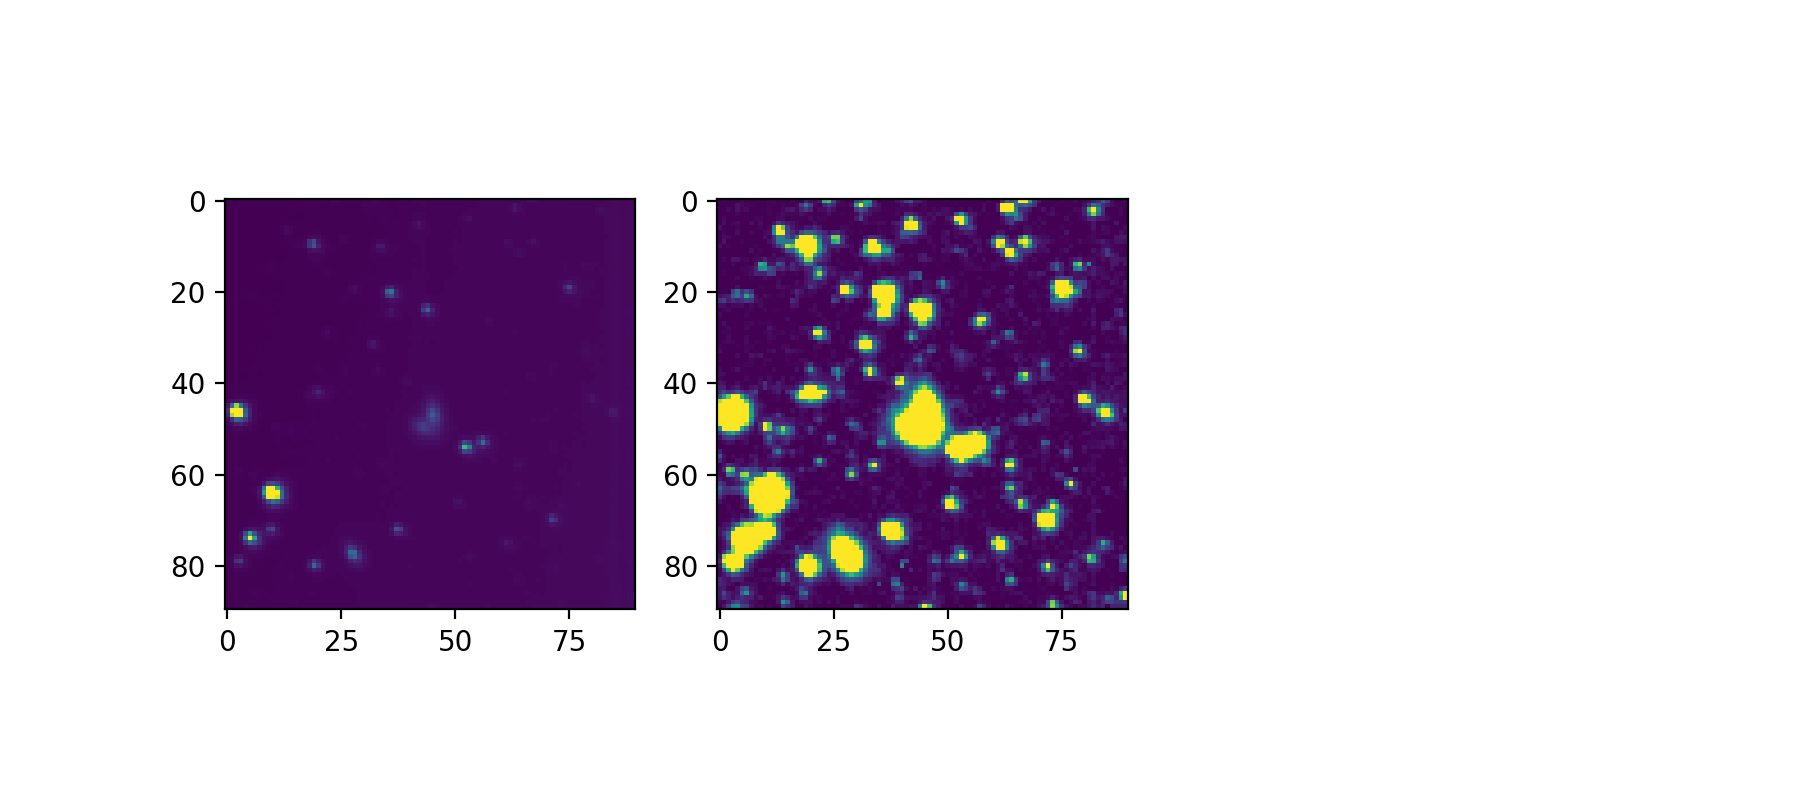

In [6]:
plt.figure(figsize=(9,4))
plt.subplot(131)
plt.imshow(tpf.flux[100],vmax=5000)

plt.subplot(132)
plt.imshow((ref),vmin=0,vmax=50)


<IPython.core.display.Javascript object>


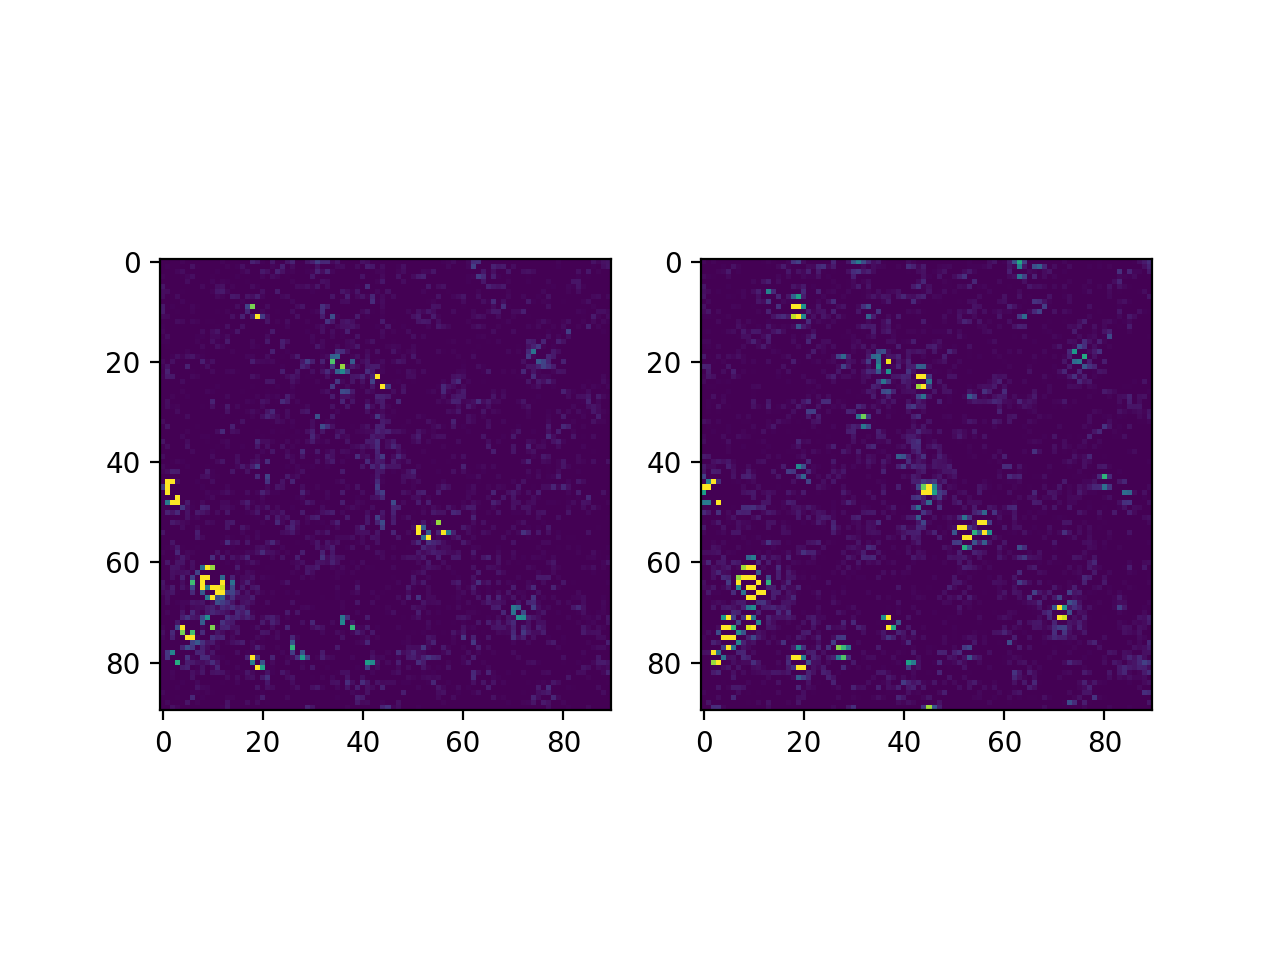

In [7]:
plt.figure()
plt.subplot(121)
plt.imshow(cor[300]-cor[100],vmin=0,vmax=20)
plt.subplot(122)
plt.imshow(cor[900]-cor[100],vmin=0,vmax=20)
#plt.colorbar()

In [44]:
3//2 == 3/2

False

In [ ]:
tpf.astropy_time.mjd

In [8]:
def diff_lc(data,time=None,x=None,y=None,ra=None,dec=None,tpf=None,tar_ap=3,sky_in=5,sky_out=7,plot=False):
    if tar_ap // 2 == tar_ap / 2:
        print(Warning('tar_ap must be odd, adding 1'))
        tar_ap += 1
    if sky_out // 2 == sky_out / 2:
        print(Warning('sky_out must be odd, adding 1'))
        sky_out += 1
    if sky_in // 2 == sky_in / 2:
        print(Warning('sky_out must be odd, adding 1'))
        sky_in += 1
        
    if (ra is not None) & (dec is not None) & (tpf is not None):
        x,y = tpf.wcs.all_world2pix(ra,dec,0)
        x = int(x + 0.5)
        y = int(y + 0.5)
    ap_tar = np.zeros_like(data[0])
    ap_sky = np.zeros_like(data[0])
    ap_tar[y,x]= 1
    ap_sky[y,x]= 1
    ap_tar = tr.convolve(ap_tar,np.ones((tar_ap,tar_ap)))
    ap_sky = tr.convolve(ap_sky,np.ones((sky_out,sky_out))) - tr.convolve(ap_sky,np.ones((sky_in,sky_in)))
    ap_sky[ap_sky == 0] = np.nan
    
    
    temp = np.nansum(data*ap_tar,axis=(1,2))
    ind = temp < np.percentile(temp,40)
    med = np.nanmedian(data[ind],axis=0)
    
    diff = data - med
    
    sky_med = np.nanmedian(ap_sky*diff,axis=(1,2))
    sky_std = np.nanstd(ap_sky*diff,axis=(1,2))
    
    tar = np.nansum(diff*ap_tar,axis=(1,2))
    tar -= sky_med * tar_ap**2
    tar_err = sky_std * tar_ap**2
    if tpf is not None:
        time = tpf.astropy_time.mjd
    lc = np.array([time, tar, tar_err])
    sky = np.array([time, sky_med, sky_std])
    
    if plot:
        dif_diag_plot(lc,sky,diff,ap_tar,ap_sky)
    
    return lc, sky
    
def dif_diag_plot(lc,sky,data,ap_tar,ap_sky):
    plt.figure(figsize=(9,4))
    plt.subplot(121)
    plt.fill_between(lc[0],lc[1]-lc[2],lc[1]+lc[2],alpha=.5)
    plt.plot(lc[0],lc[1],'.',label='Target')
    plt.fill_between(lc[0],sky[1]-sky[2],sky[1]+sky[2],alpha=.5,color='C1')
    plt.plot(sky[0],sky[1],'.',label='Sky')
    plt.xlabel('MJD')
    plt.ylabel('Counts')
    plt.legend(loc=4)
    plt.subplot(122)
    maxind = np.where((np.nanmax(lc[1]) == lc[1]))[0][0]
    plt.imshow(data[maxind],origin='lower',
               vmin=np.percentile(data[maxind],16),
               vmax=np.percentile(data[maxind],99),
               aspect='auto')
    plt.colorbar()
    ap = ap_tar
    ap[ap==0] = np.nan
    #plt.imshow(ap,origin='lower',alpha = 0.2)
    #plt.imshow(ap_sky,origin='lower',alpha = 0.8,cmap='hot')
    y,x = np.where(ap_sky > 0)
    plt.plot(x,y,'r.',alpha = 0.3)
    
    y,x = np.where(ap > 0)
    plt.plot(x,y,'C1.',alpha = 0.3)

    return

<IPython.core.display.Javascript object>


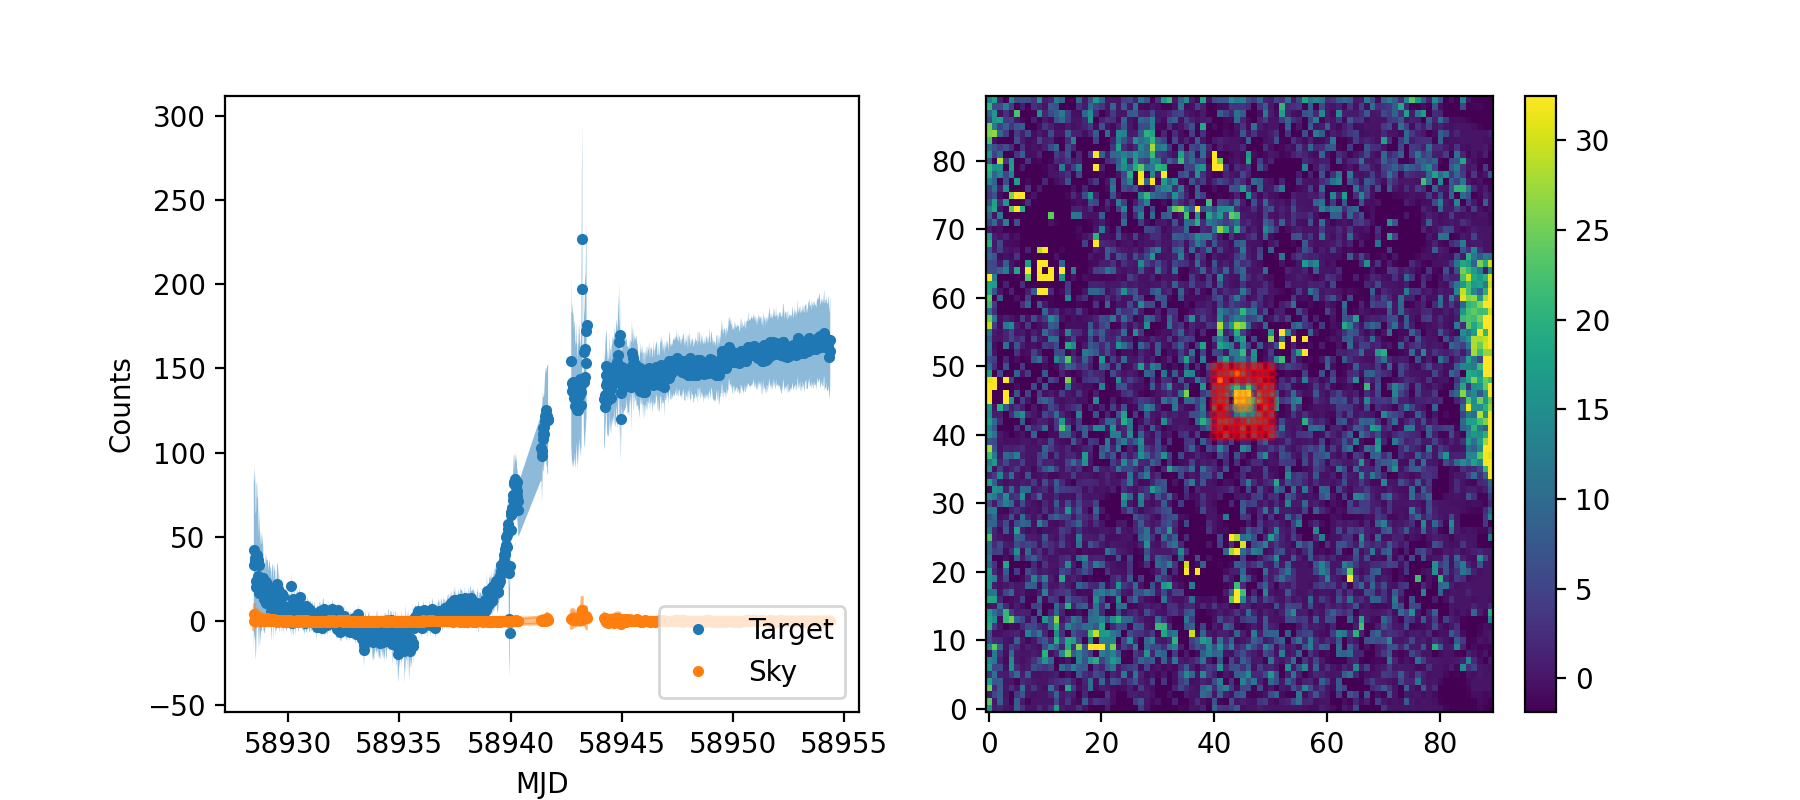

In [9]:
lc,sky = diff_lc(cor,tpf=tpf,ra=ra,dec=dec,plot=True,tar_ap=3,sky_in=5,sky_out=11)

<IPython.core.display.Javascript object>


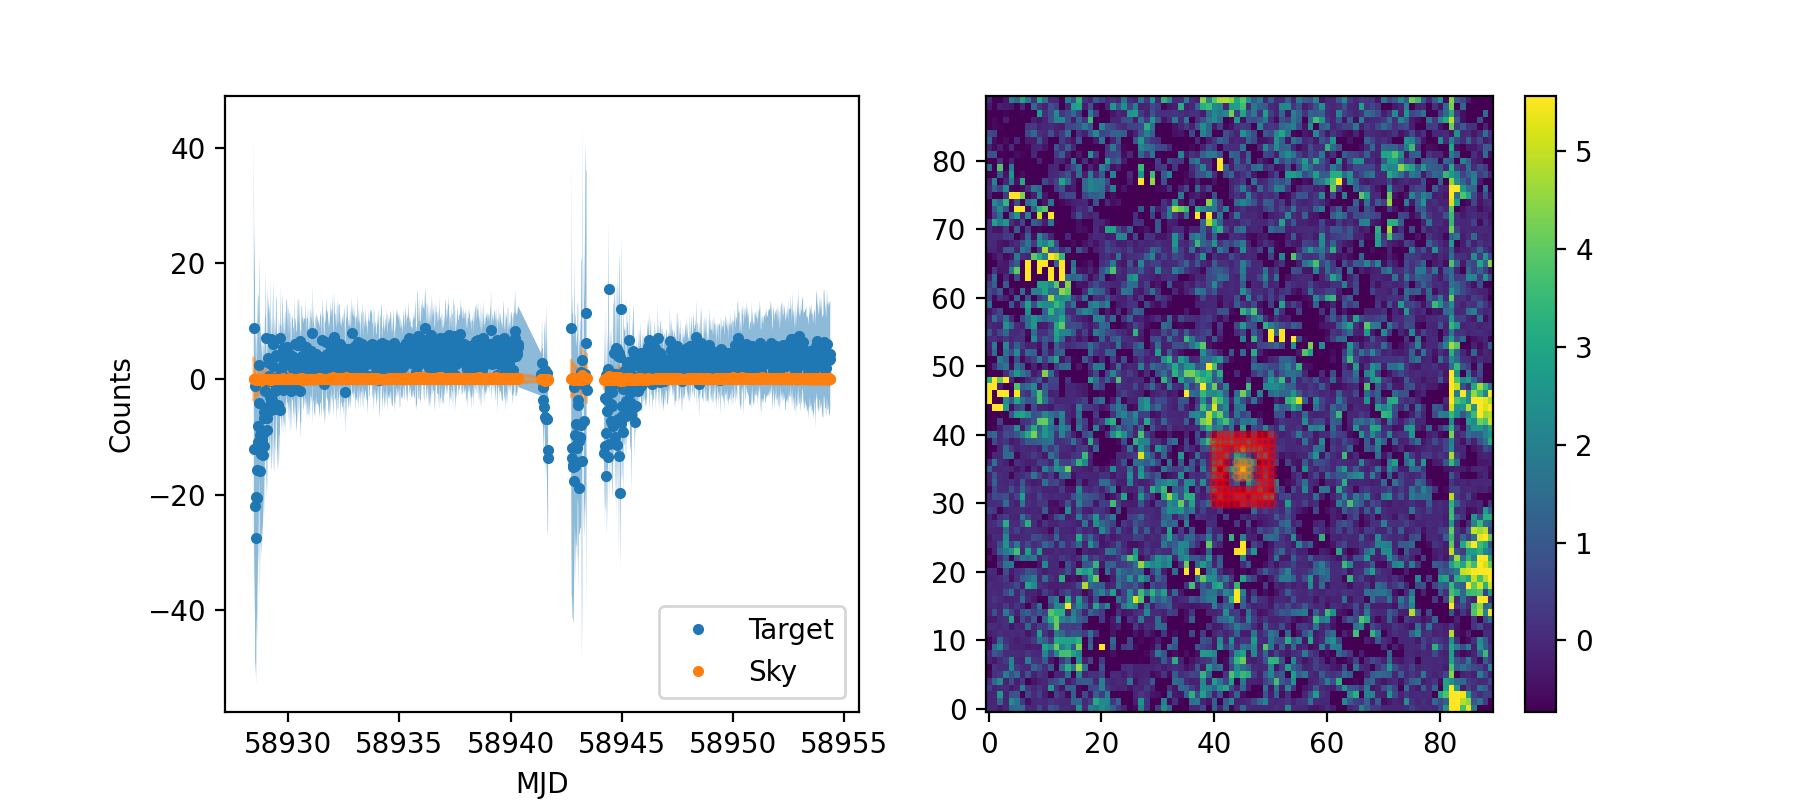

In [10]:
lc2,sky2 = diff_lc(cor,tpf=tpf,x=45,y=35,plot=True,tar_ap=3,sky_in=5,sky_out=11)

<IPython.core.display.Javascript object>


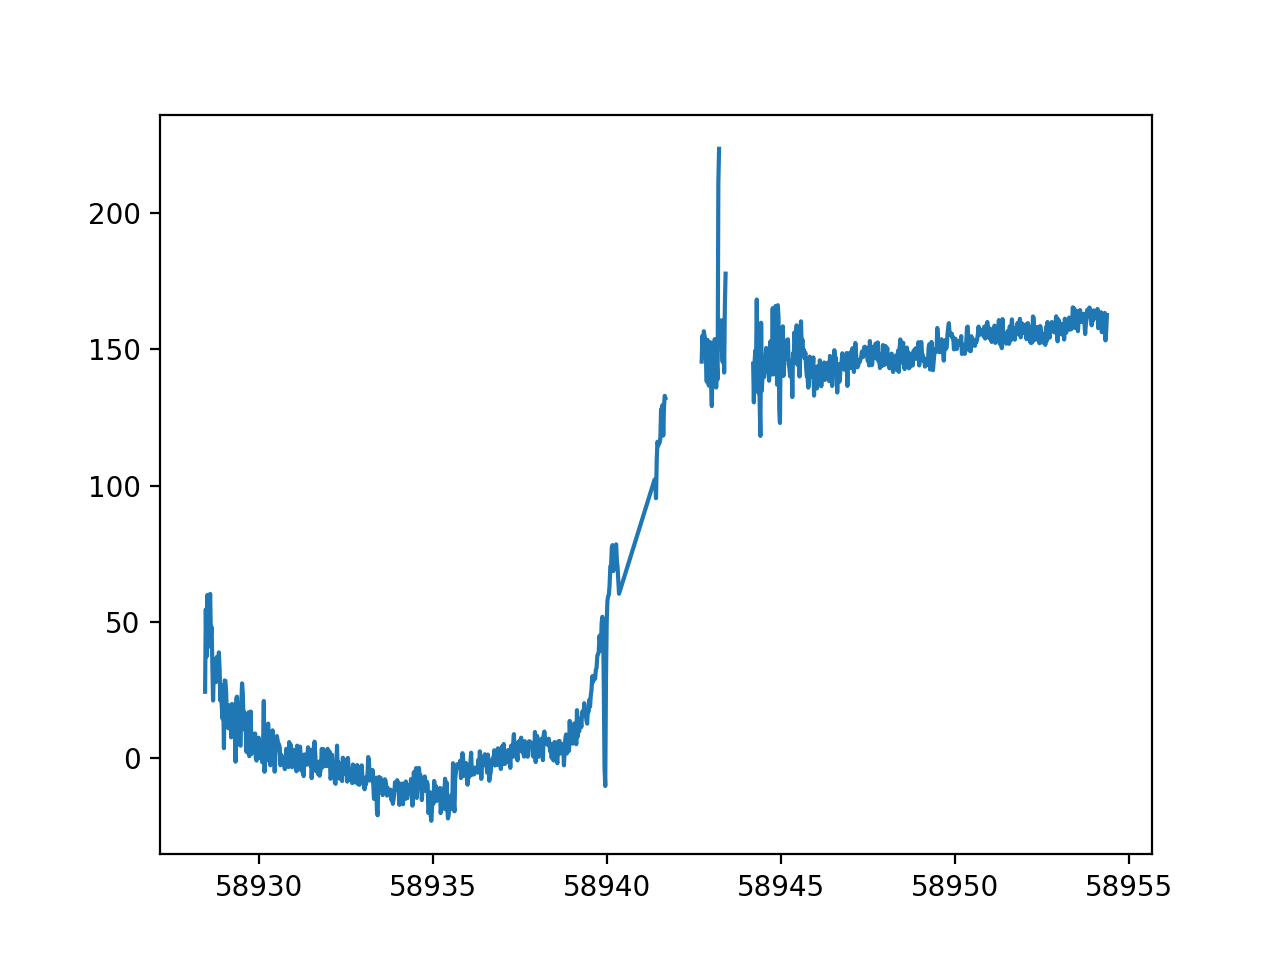

In [11]:
plt.figure()
plt.plot(lc[0],lc[1]-lc2[1])

In [55]:
np.savetxt('../../SN_individual/2020fqv/diff_lc.txt',lc)

<IPython.core.display.Javascript object>


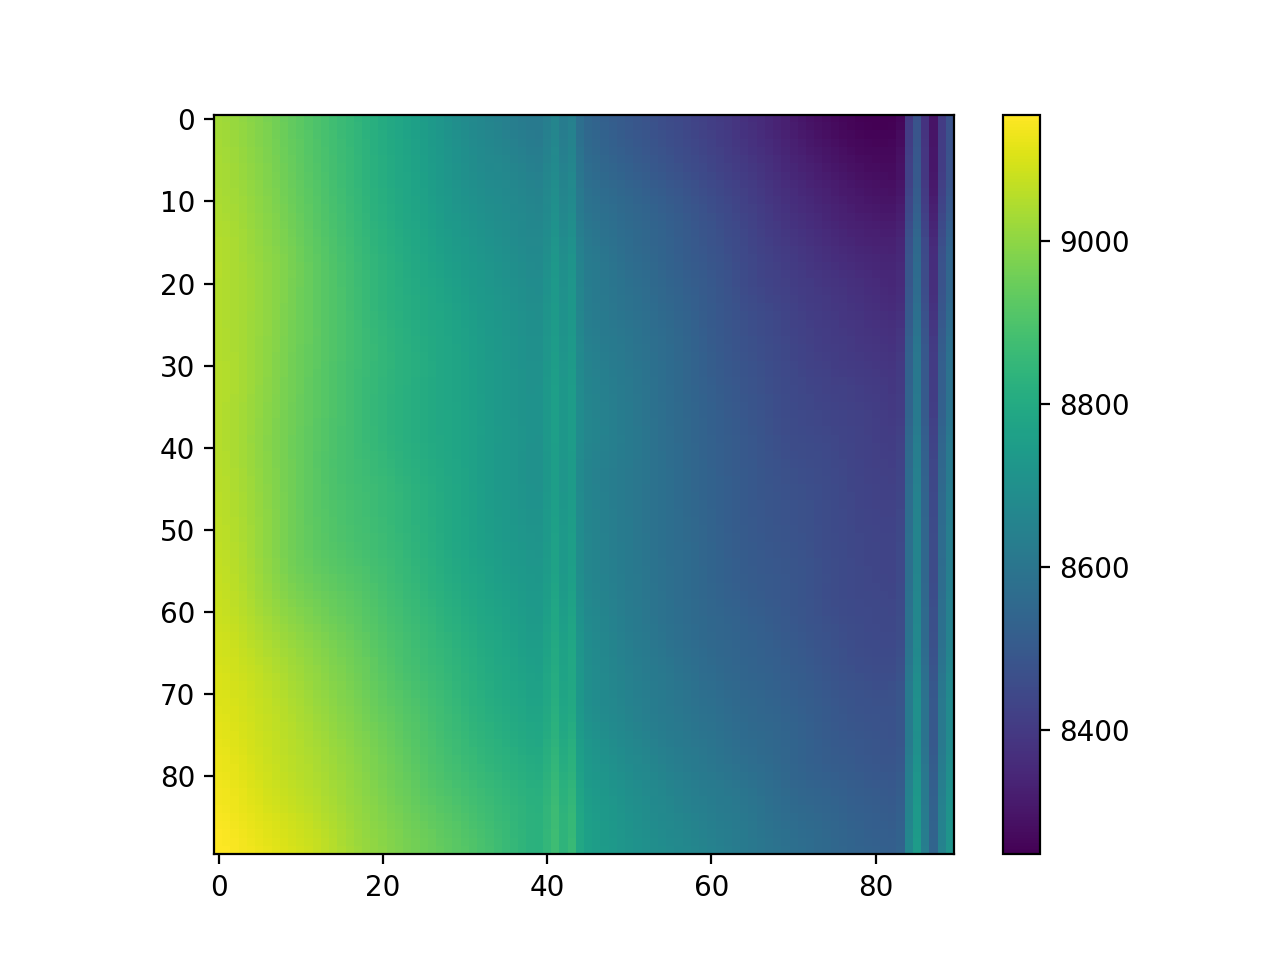

In [14]:
plt.figure()
plt.imshow(bkg[700])
plt.colorbar()

<IPython.core.display.Javascript object>


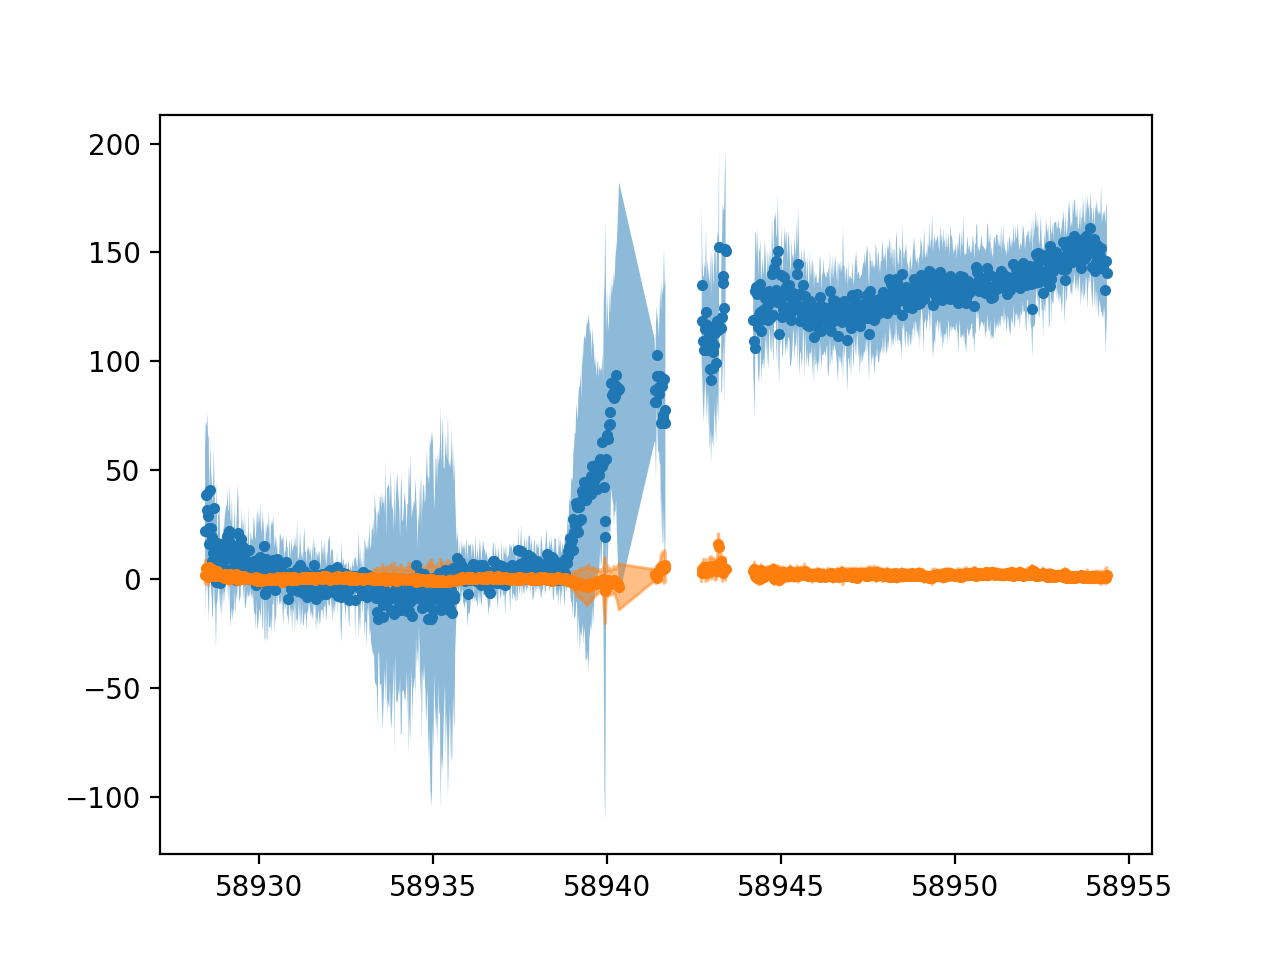

In [100]:
plt.figure()
plt.fill_between(t,lc[1]-lc[2],lc[1]+lc[2],alpha=.5)
plt.plot(lc[0],lc[1],'.')
plt.fill_between(t,sky[1]-sky[2],sky[1]+sky[2],alpha=.5,color='C1')
plt.plot(sky[0],sky[1],'.')

In [34]:
t,f = tr.Make_lc(tpf.astropy_time.mjd,cor[:]-cor[100])

<IPython.core.display.Javascript object>


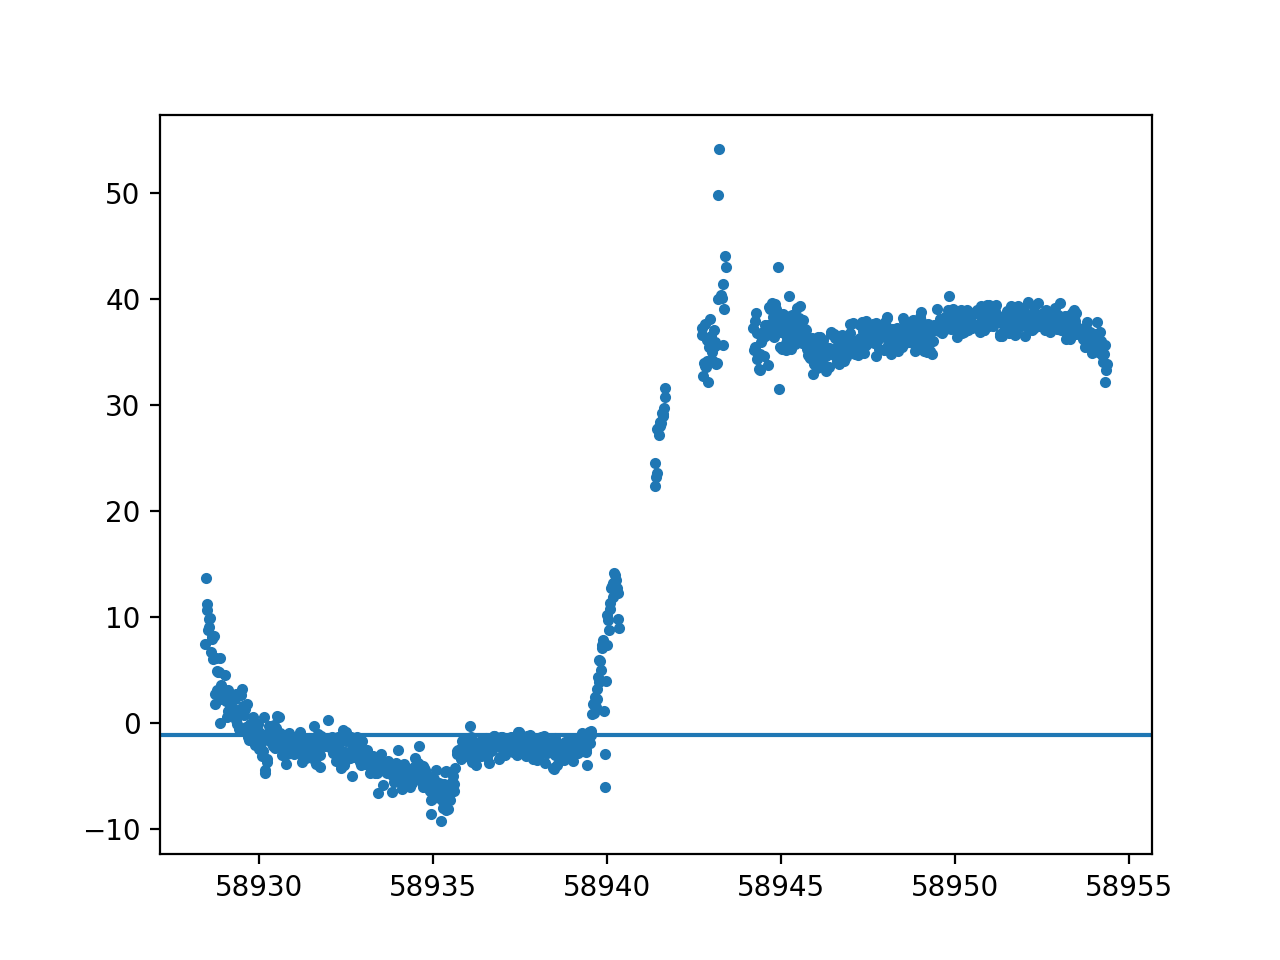

In [74]:
f2 = np.nansum(cor[:,44+10:47+10,44:47],axis=(1,2))
f = np.nansum(cor[:,44:47,44:47]-cor[100,44:47,44:47],axis=(1,2))
f = cor[:,45,45]-cor[100,45,45]
f[f==0] = np.nan
f2[f2==0] = np.nan
ff = f
plt.figure()
#plt.plot(t,ff-np.nanmedian(ff[:300]),'.')
plt.plot(t,ff,'.')
plt.axhline(np.percentile(ff[np.isfinite(ff)],40))
#plt.plot(t,f2,'.')

In [63]:
lc = np.array([t,ff])

In [65]:
a = tr.Remove_background_var(lc,)

could not cluster


In [67]:
a.shape

(2, 1235)

<IPython.core.display.Javascript object>


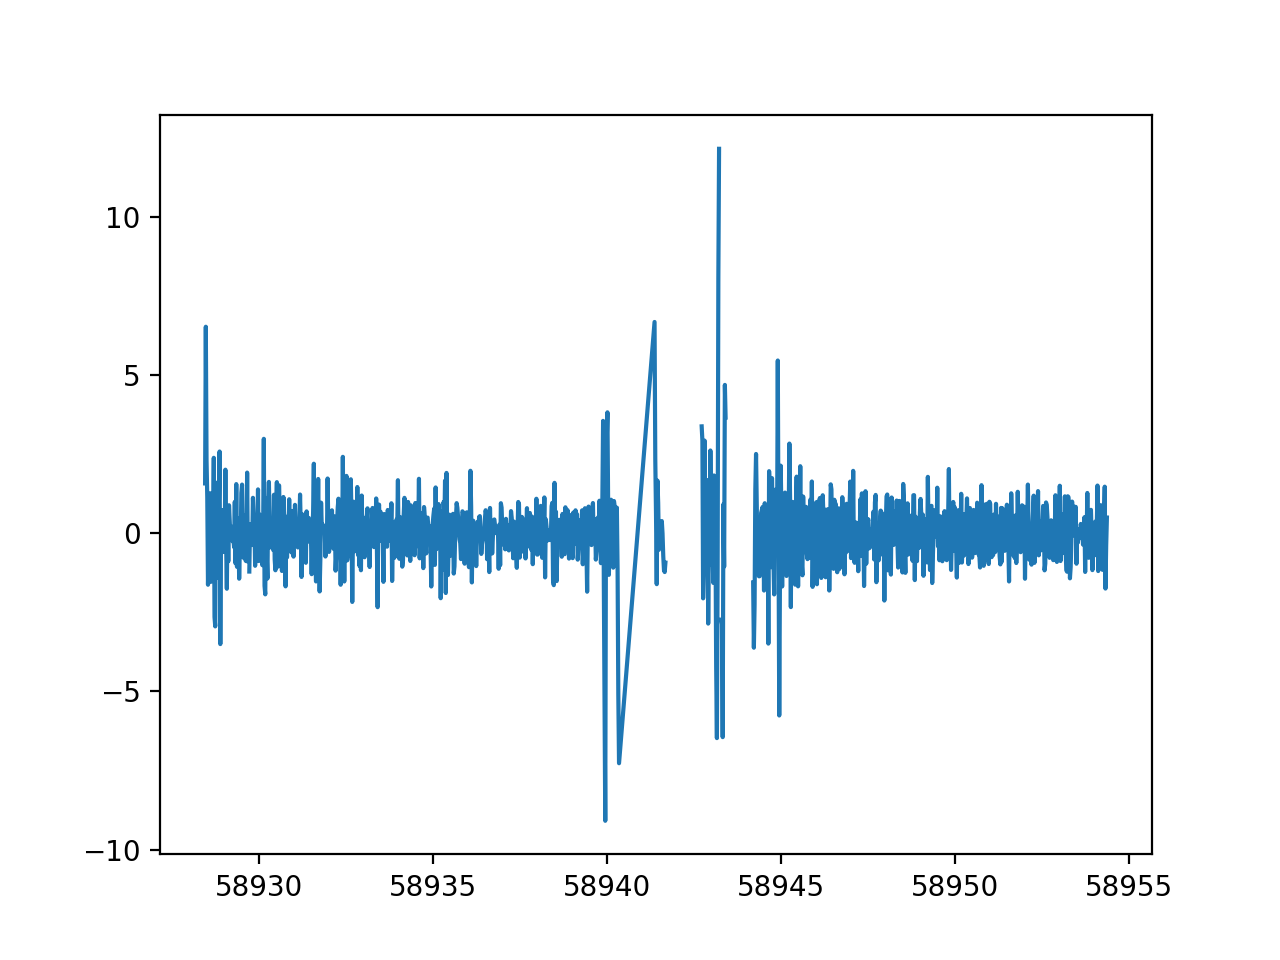

In [68]:
plt.figure()
plt.plot(a[0],a[1])

In [8]:
strap = ((mask & 4) > 0) * 1.
strap[strap==0] = np.nan

<IPython.core.display.Javascript object>


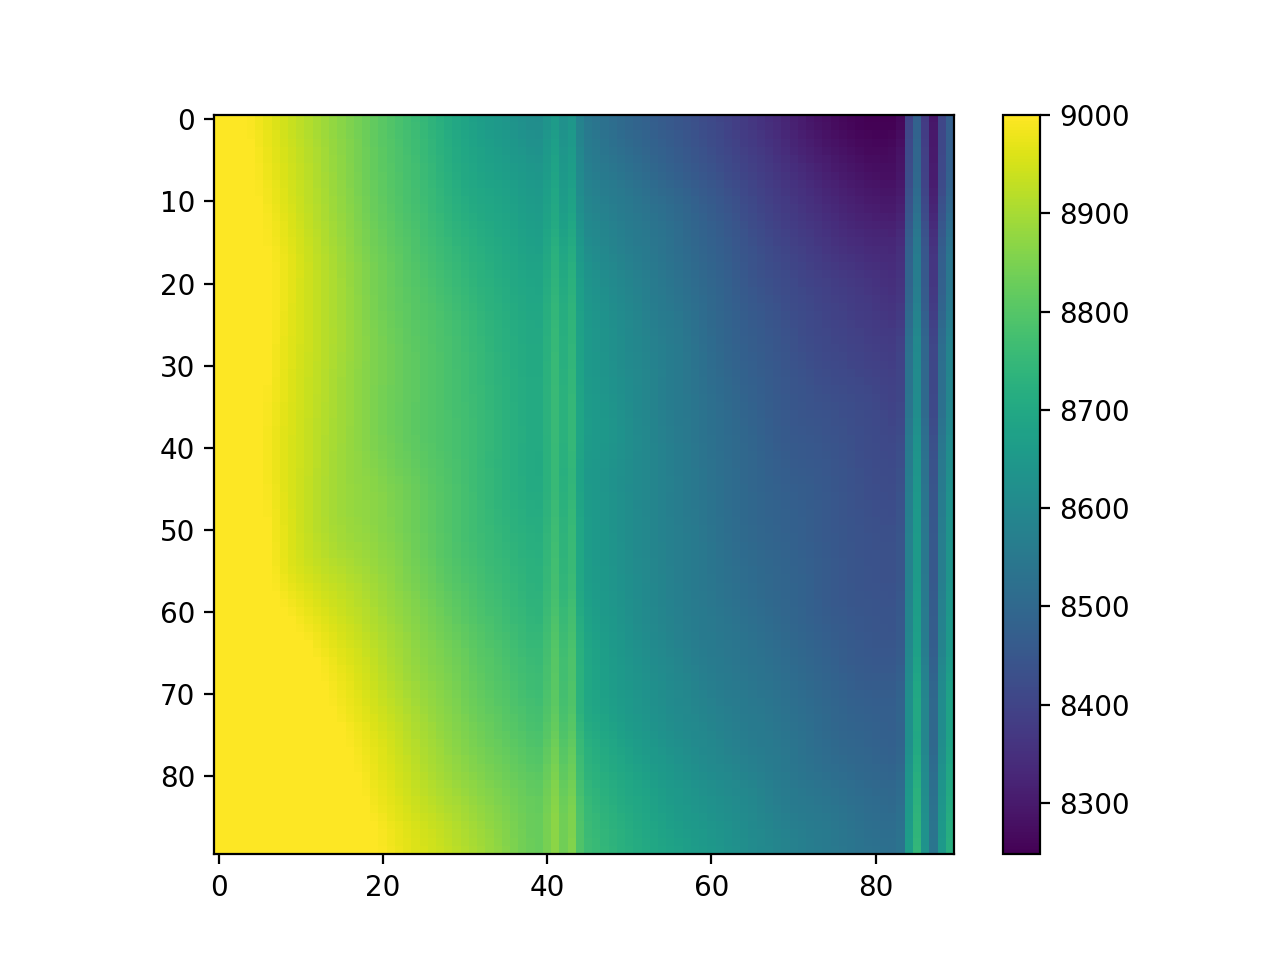

In [57]:
plt.figure()
plt.imshow(bkg[700],vmax=9e3)
plt.colorbar()

In [20]:
s = (ref*strap* mm)/bkg_smth[700]
q = np.zeros_like(s)
for i in range(s.shape[1]):
    q[:,i] = np.nanmedian(s[:,i])
q[np.isnan(q)] =1 

<IPython.core.display.Javascript object>


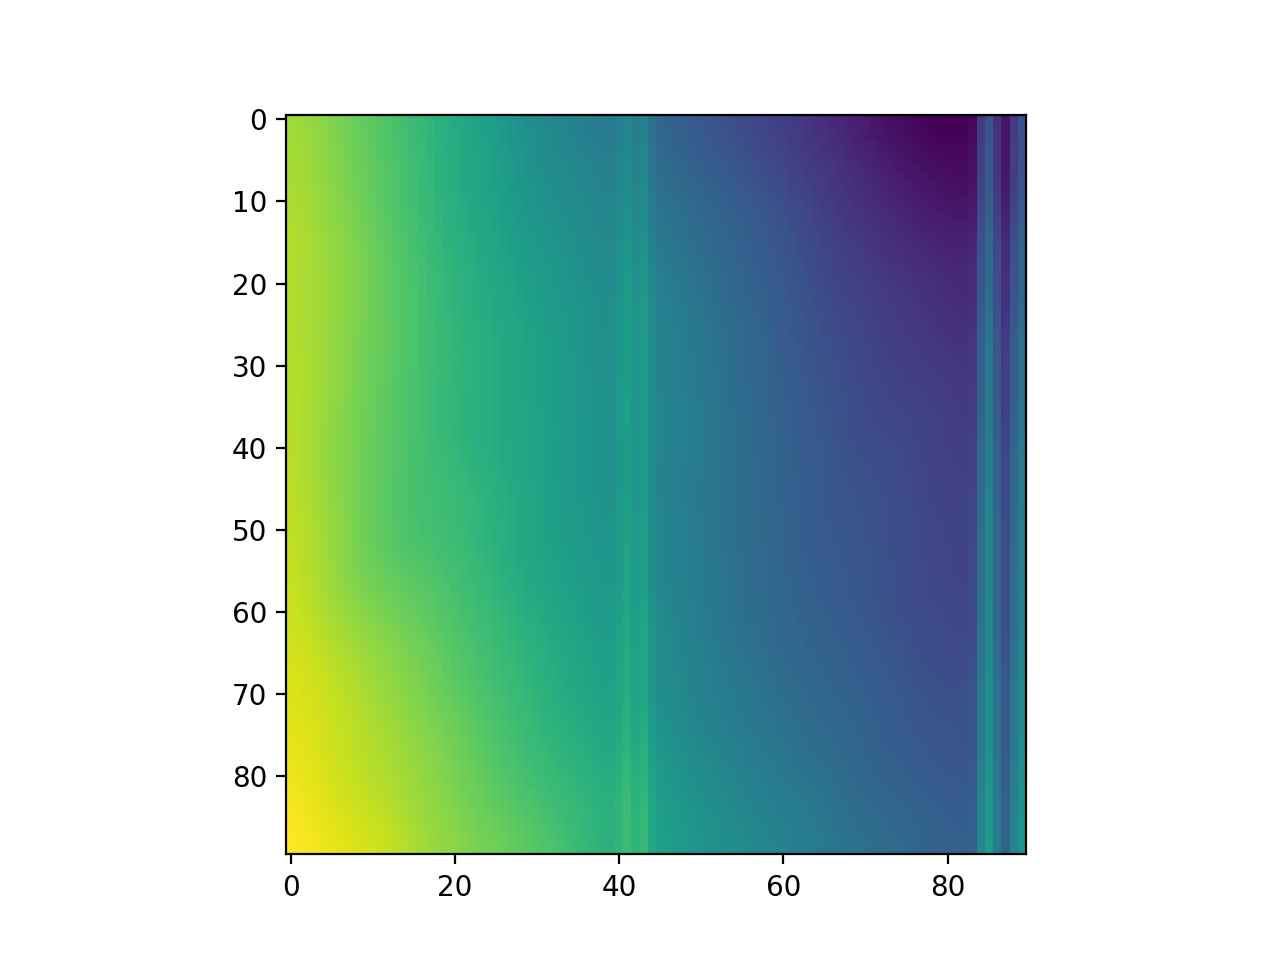

In [14]:
plt.figure()
plt.imshow(bkg[700])

In [33]:
m = abs((mask & 1)) * 1.
bkg_smth = tr.Background(tpf,m,include_straps=False)
mm = abs(m -1)*1.
mm[mm==0] = np.nan
strap = ((mask & 4) > 0) * 1.
strap[strap==0] = np.nan

In [34]:


data = tpf.flux
qes = np.zeros_like(bkg_smth) * np.nan
for i in range(data.shape[0]):
    s = (data[i]*strap* mm)/bkg_smth[i]
    q = np.zeros_like(s) * np.nan
    for i in range(s.shape[1]):
        q[:,i] = np.nanmedian(s[:,i])
    q[np.isnan(q)] =1 
    if i == 100:
        asdf

<IPython.core.display.Javascript object>


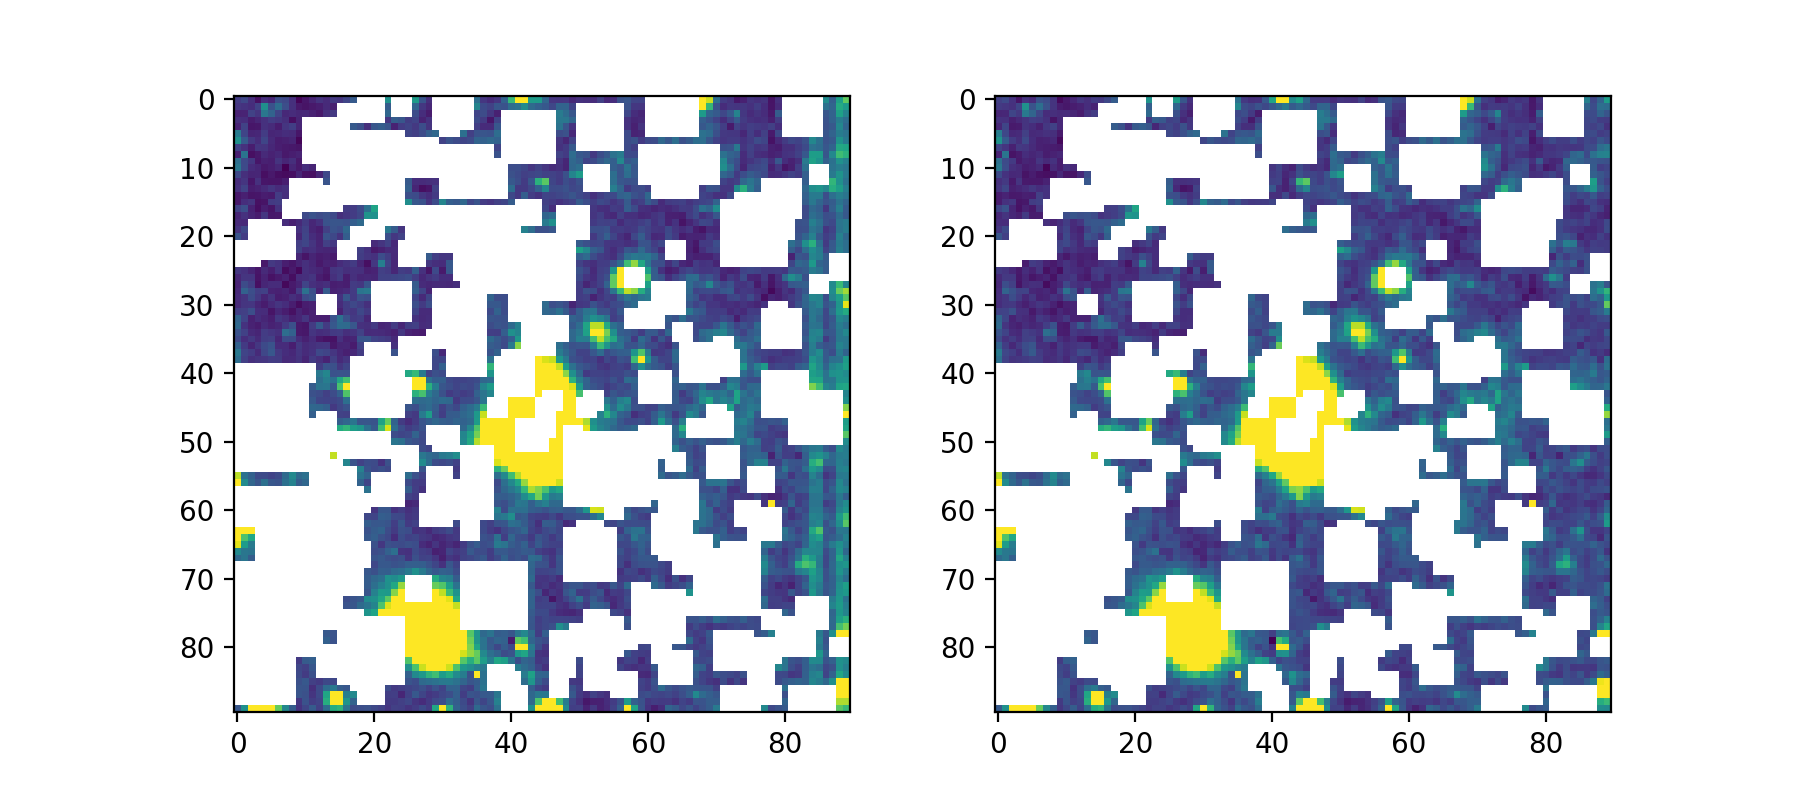

In [11]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(ref,vmax=130)
plt.subplot(122)
plt.imshow(qe*ref,vmax=130)

<IPython.core.display.Javascript object>


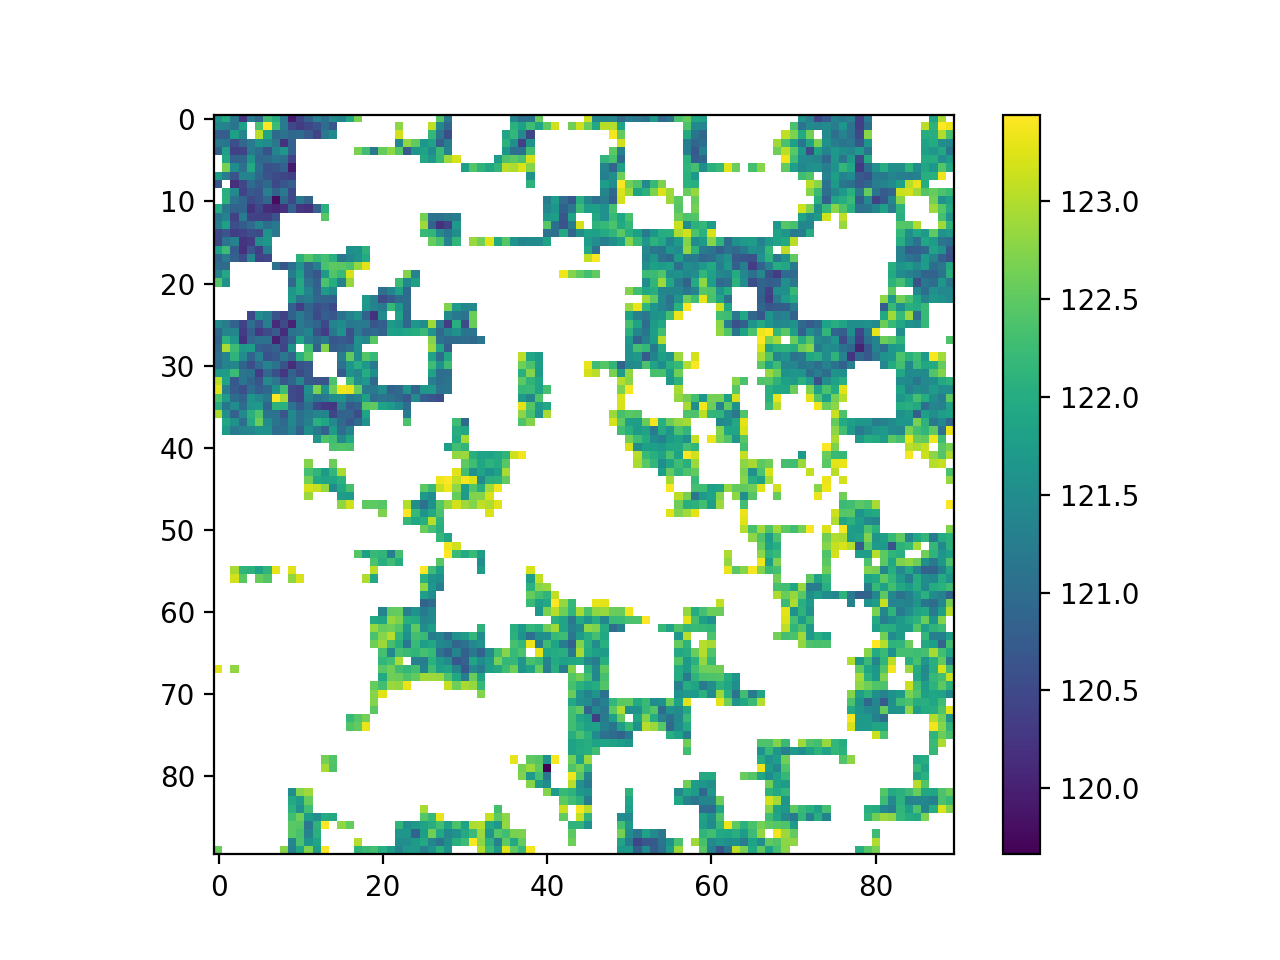

In [18]:
mm = tr.Source_mask(ref * qe * sources)
mm[mm==0] = np.nan
plt.figure()
plt.imshow(mm*ref*qe)
plt.colorbar()

In [15]:
test = tpf.flux - bkg

offset = tr.Centroids_DAO(test,ref,TPF=tpf,parallel=False)

flux = tr.Shift_images(offset,test)

<IPython.core.display.Javascript object>


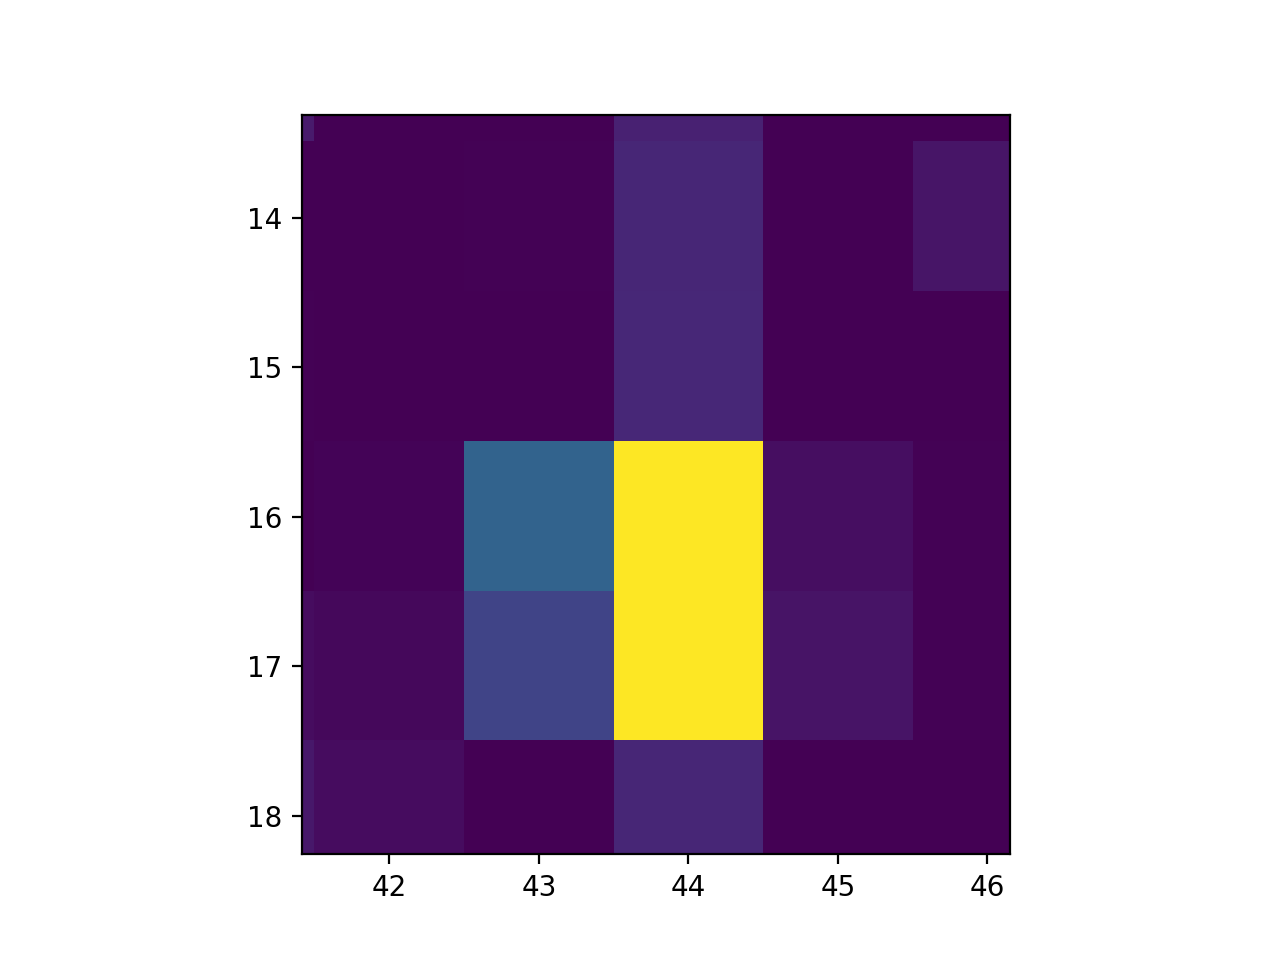

In [16]:
plt.figure()
plt.imshow(flux[700]-flux[100],vmin=0,vmax=100)

<IPython.core.display.Javascript object>


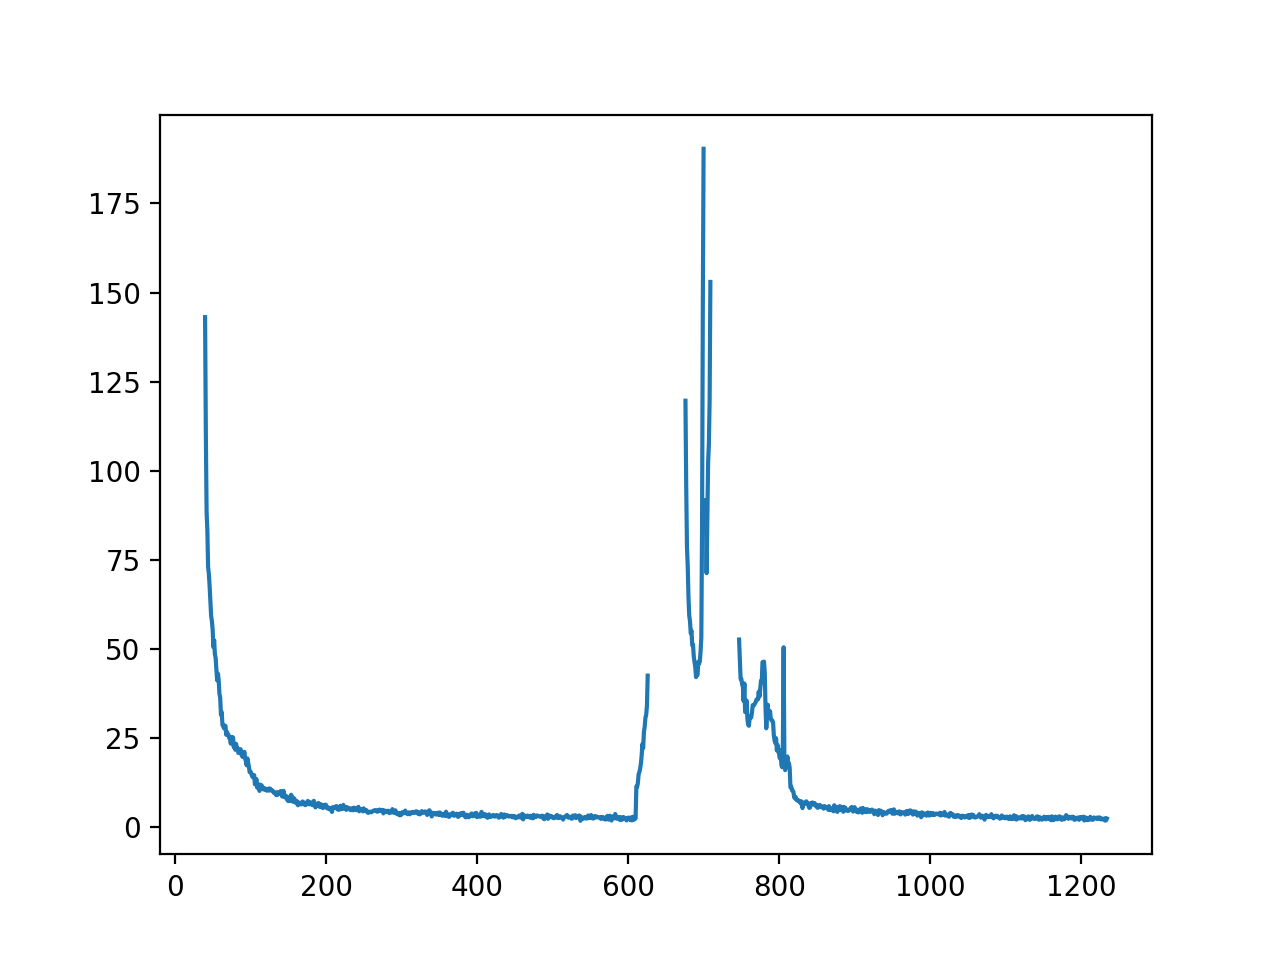

In [24]:
plt.figure()
plt.plot(flux[:,16,44]/bkg)

In [47]:
import numpy as np
from copy import deepcopy
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from astropy.stats import sigma_clip
from astropy.io import fits
import multiprocessing
from joblib import Parallel, delayed

# turn off runtime warnings (lots from logic on nans)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

def grad_clip(data,box_size=100):
    """
    Perform a local sigma clip of points based on the gradient of the points. 
    Pixels with large gradients are contaminated by stars/galaxies.

    Inputs
    ------
        data : array
            1d array of the data to clip
        box_size : int 
            integer defining the box size to clip over 
    Output
    ------
        gradind : bool

    """
    gradind = np.zeros_like(data)
    
    for i in range(len(data)):
        if i < box_size//2:
            d = data[:i+box_size//2]
        elif len(data) - i < box_size//2:
            d = data[i-box_size//2:]
        else:
            d = data[i-box_size//2:i+box_size//2]
        
        ind = np.isfinite(d)
        d = d[ind]
        if len(d) > 5:
            gind = ~sigma_clip(np.gradient(abs(d))+d,sigma=2).mask

            if i < box_size//2:
                gradind[:i+box_size//2][ind] = gind
            elif len(data) - i < box_size//2:
                gradind[i-box_size//2:][ind] = gind
            else:
                gradind[i-box_size//2:i+box_size//2][ind] = gind
    
    gradind = gradind > 0
    return gradind 

def fit_strap(data):
    """
    interpolate over missing data

    """
    x = np.arange(0,len(data))
    y = data.copy()
    y[~grad_clip(y)] = np.nan
    lim = np.percentile(y[np.isfinite(y)],50)
    y[y >= lim] = np.nan

    finite = np.isfinite(y)
    p =np.ones_like(x) * np.nan
    if len(y[finite]) > 5:
        finite = np.isfinite(y)
        #y = median_clipping(y)
        finite = np.where(finite)[0]
        finite = np.isfinite(y)
        #y[finite] = savgol_filter(y[finite],11,3)
        p = interp1d(x[finite], y[finite],bounds_error=False,fill_value=np.nan,kind='nearest')
        p = p(x)
        p[np.isfinite(p)] = savgol_filter(p[np.isfinite(p)],31,1)
    return p

from copy import deepcopy

def calc_strap_factor(i,breaks,size,av_size,normals,data):
    qe = np.ones_like(data) * 1. * np.nan
    b = int(breaks[i])
    size = size.astype(int)
    nind = normals[b-av_size:b]
    eind = normals[b:b+av_size]
    nind = np.append(nind,eind) + 1
    nind = nind[nind<data.shape[1]-1]
    nind = nind[nind >= 0]
    norm = fit_strap(np.nanmedian(data[:,nind],axis=1))
    for j in range(size[i]): 
        ind =  normals[b]+1+j
        if (ind > 0) & (ind < data.shape[1]):
            s1 = fit_strap(data[:,ind])
            plt.figure()
            plt.plot(s1,label='strap')
            plt.plot(norm,'-',label='normal')
            plt.legend()
            factor = np.nanmedian(norm/s1)
            qe[:,normals[b]+1+j] = factor
    return qe

def correct_straps(Image,mask,av_size=5,parallel=True):
    data = deepcopy(Image)
    mask = deepcopy(mask)
    av_size = int(av_size)
    sind = np.where(np.nansum((mask & 4),axis=0)>0)[0]
    normals = np.where(np.nansum((mask & 4),axis=0)==0)[0]
    normals = np.append(normals,data.shape[1])
    normals = np.insert(normals,0,-1)
    breaks = np.where(np.diff(normals,append=0)>1)[0]
    breaks[breaks==-1] = 0
    size = (np.diff(normals,append=0))[np.diff(normals,append=0)>1]

    if parallel:
        num_cores = multiprocessing.cpu_count()
        x = np.arange(0,len(breaks),dtype=int)
        qe = np.array(Parallel(n_jobs=num_cores)(delayed(calc_strap_factor)(i,breaks,size,av_size,normals,data) for i in x))
        qe = np.nanmedian(qe,axis=0)
        qe[np.isnan(qe)] = 1   
    else:
        qe = []
        for i in range(len(breaks)):
            qe += [calc_strap_factor(i,breaks,size,av_size,normals,data)]
        qe = np.array(qe)
        qe = np.nanmedian(qe,axis=0)
        qe[np.isnan(qe)] = 1   

    return qe

<IPython.core.display.Javascript object>


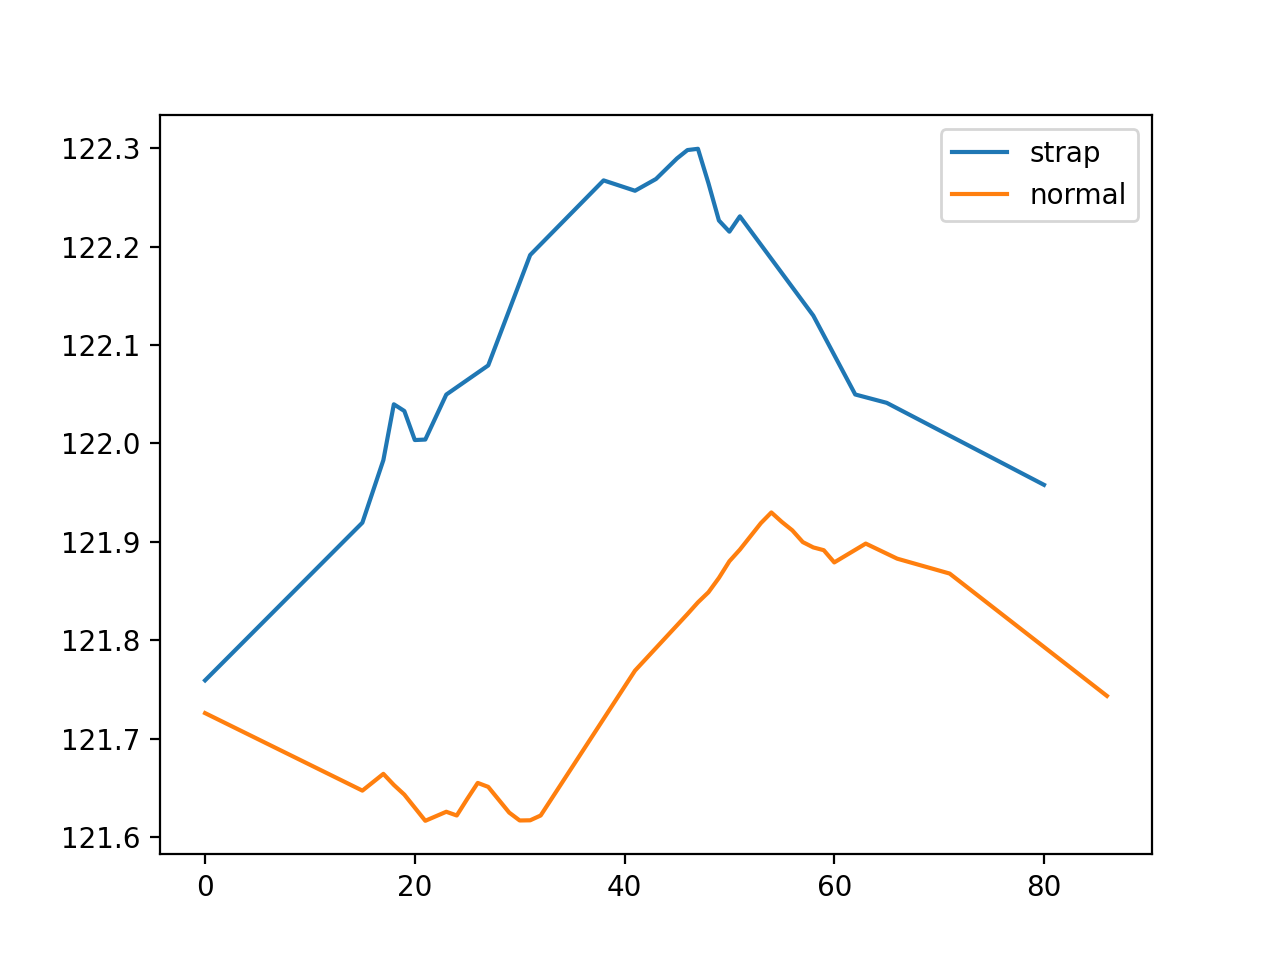

<IPython.core.display.Javascript object>


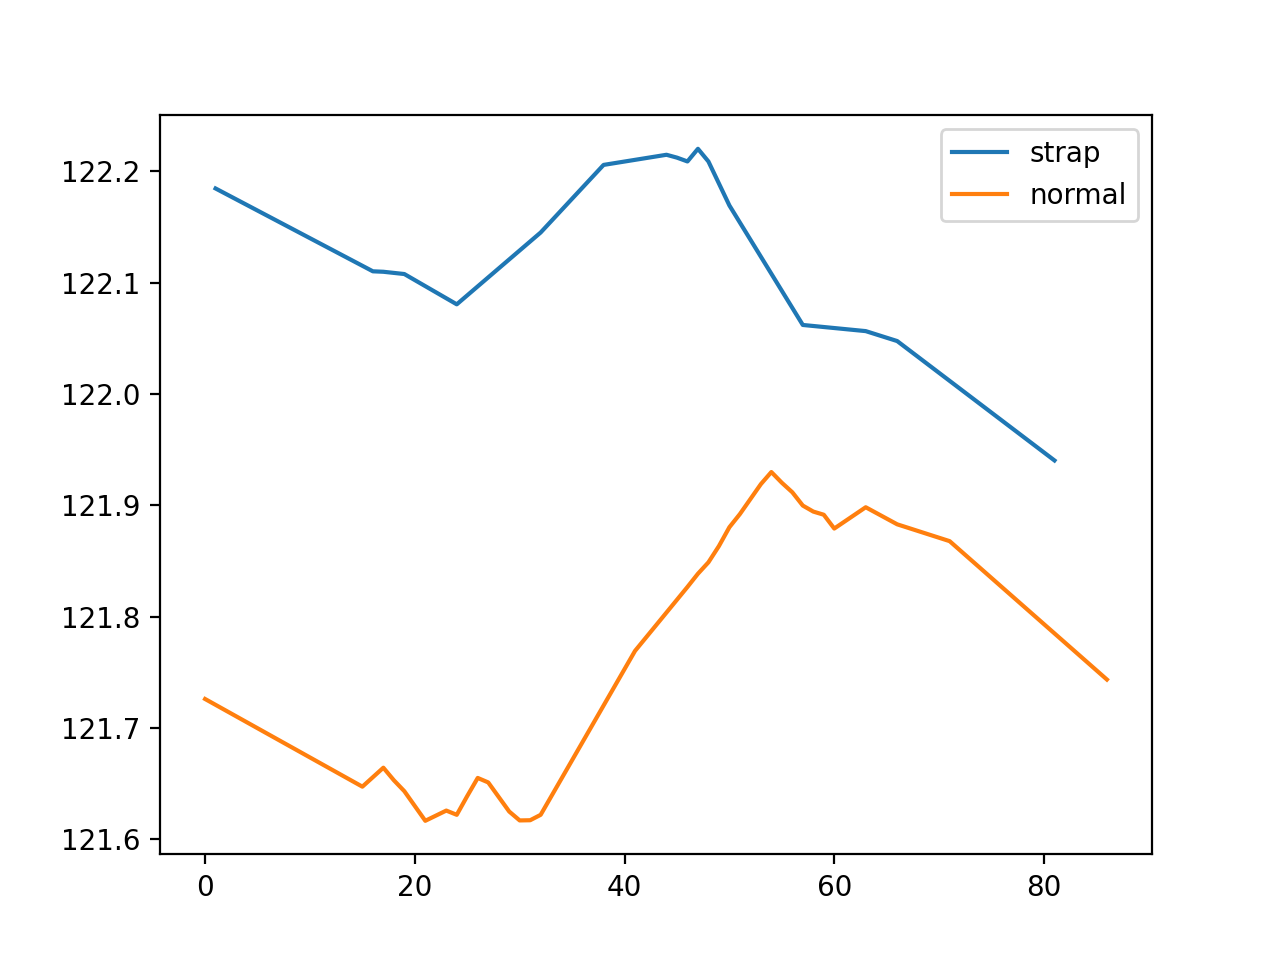

<IPython.core.display.Javascript object>


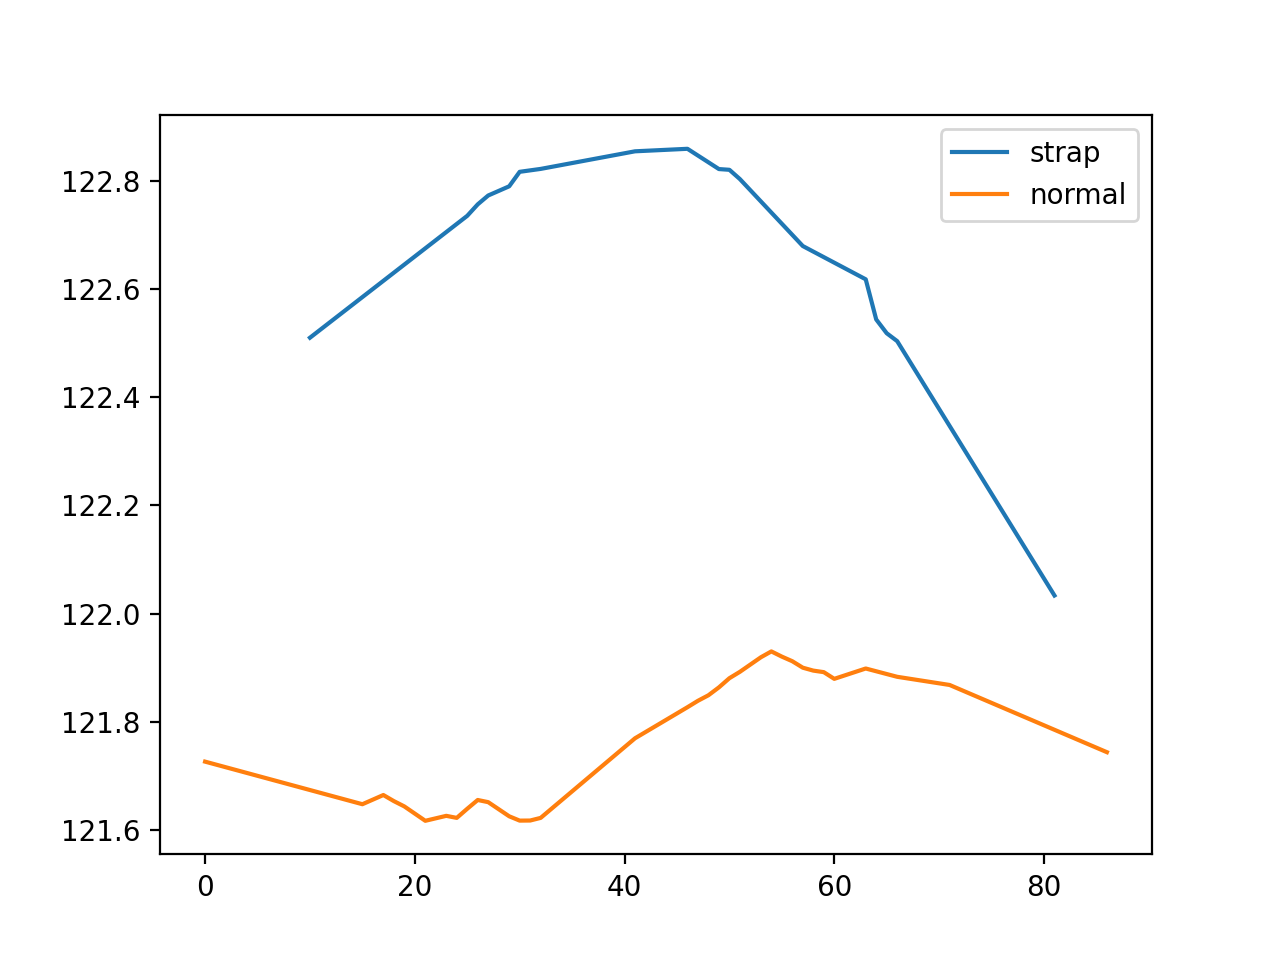

<IPython.core.display.Javascript object>


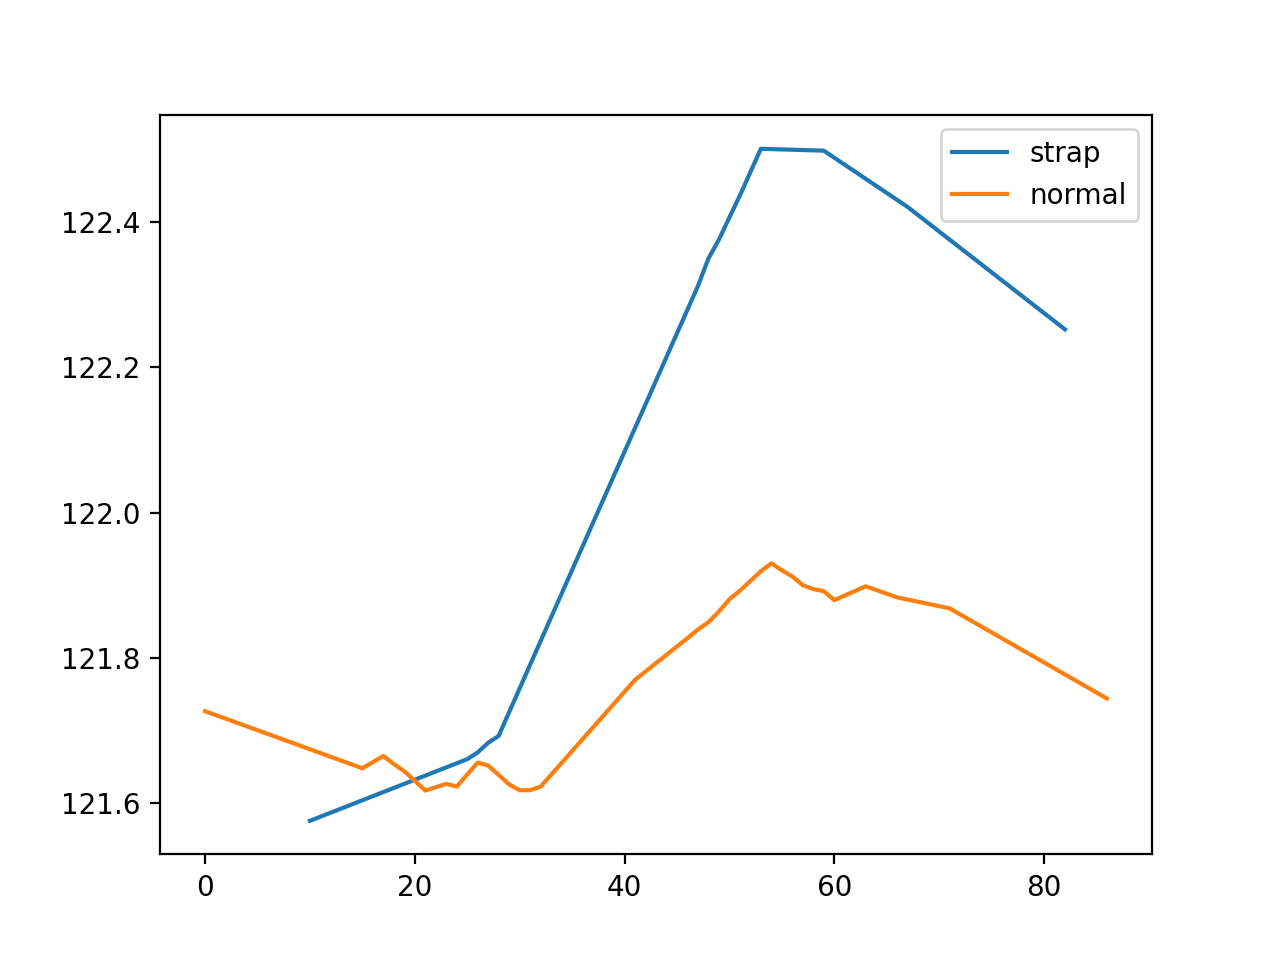

<IPython.core.display.Javascript object>


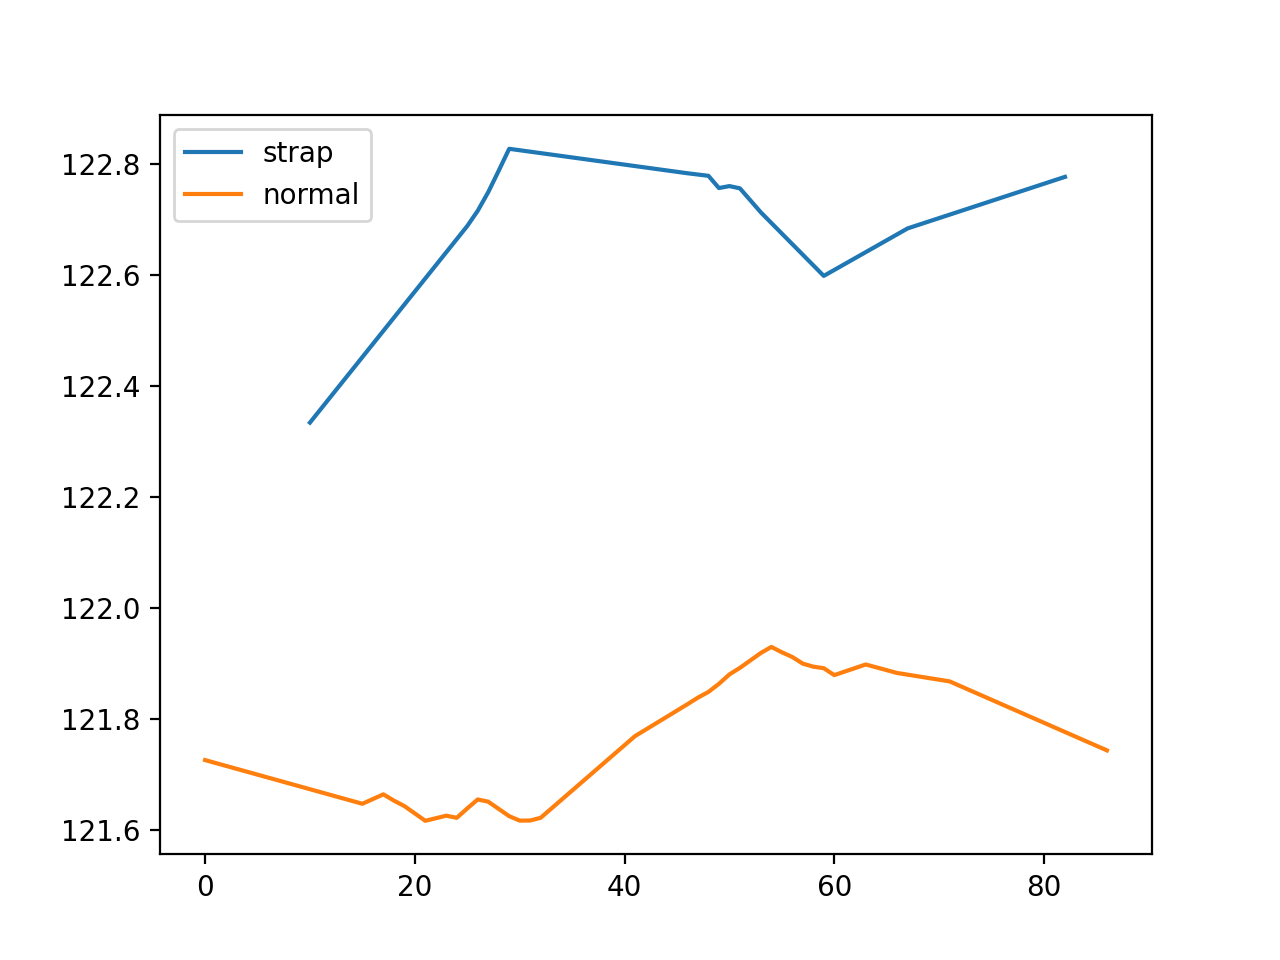

<IPython.core.display.Javascript object>


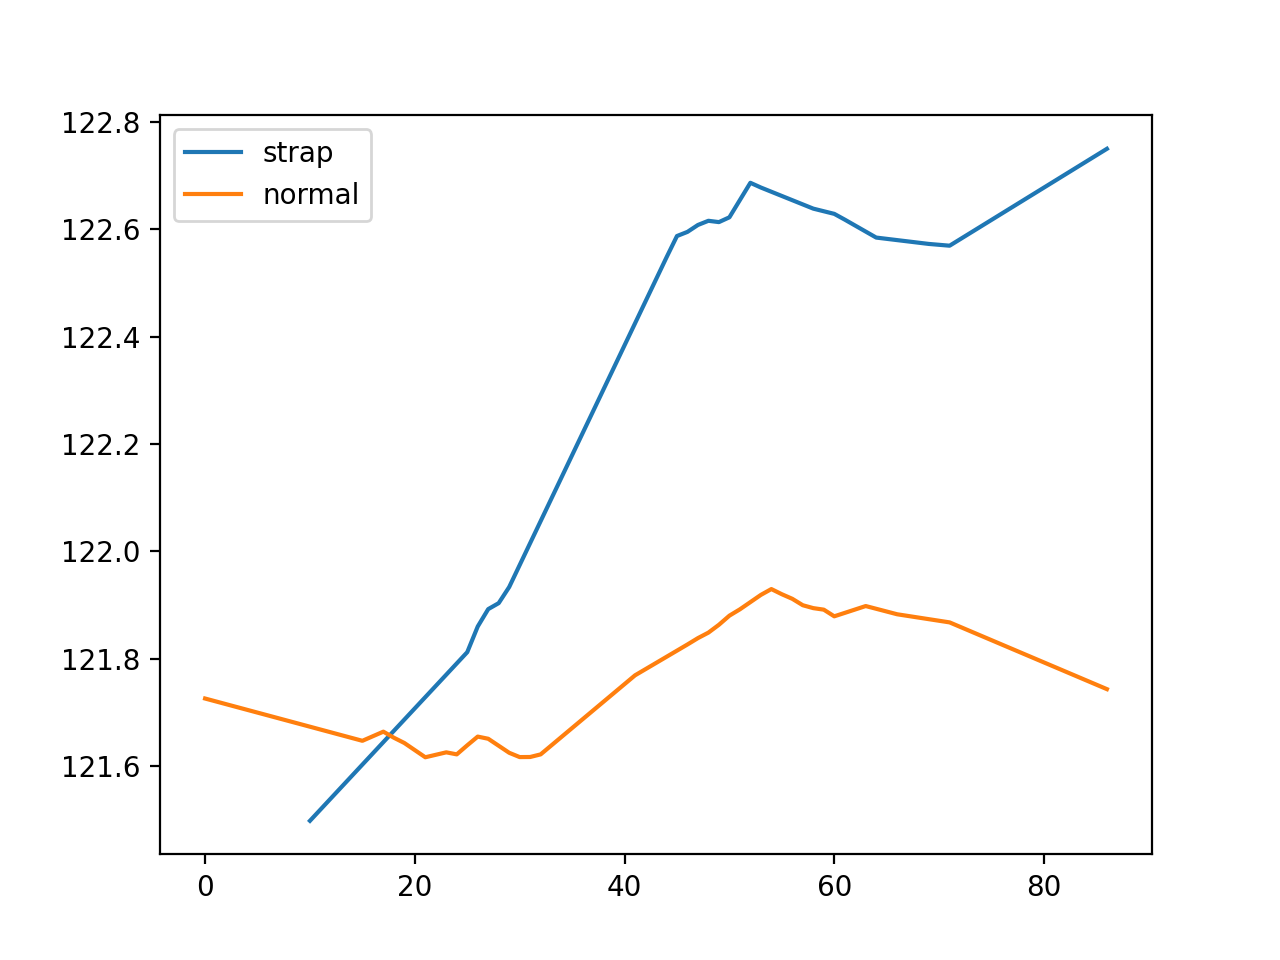

<IPython.core.display.Javascript object>


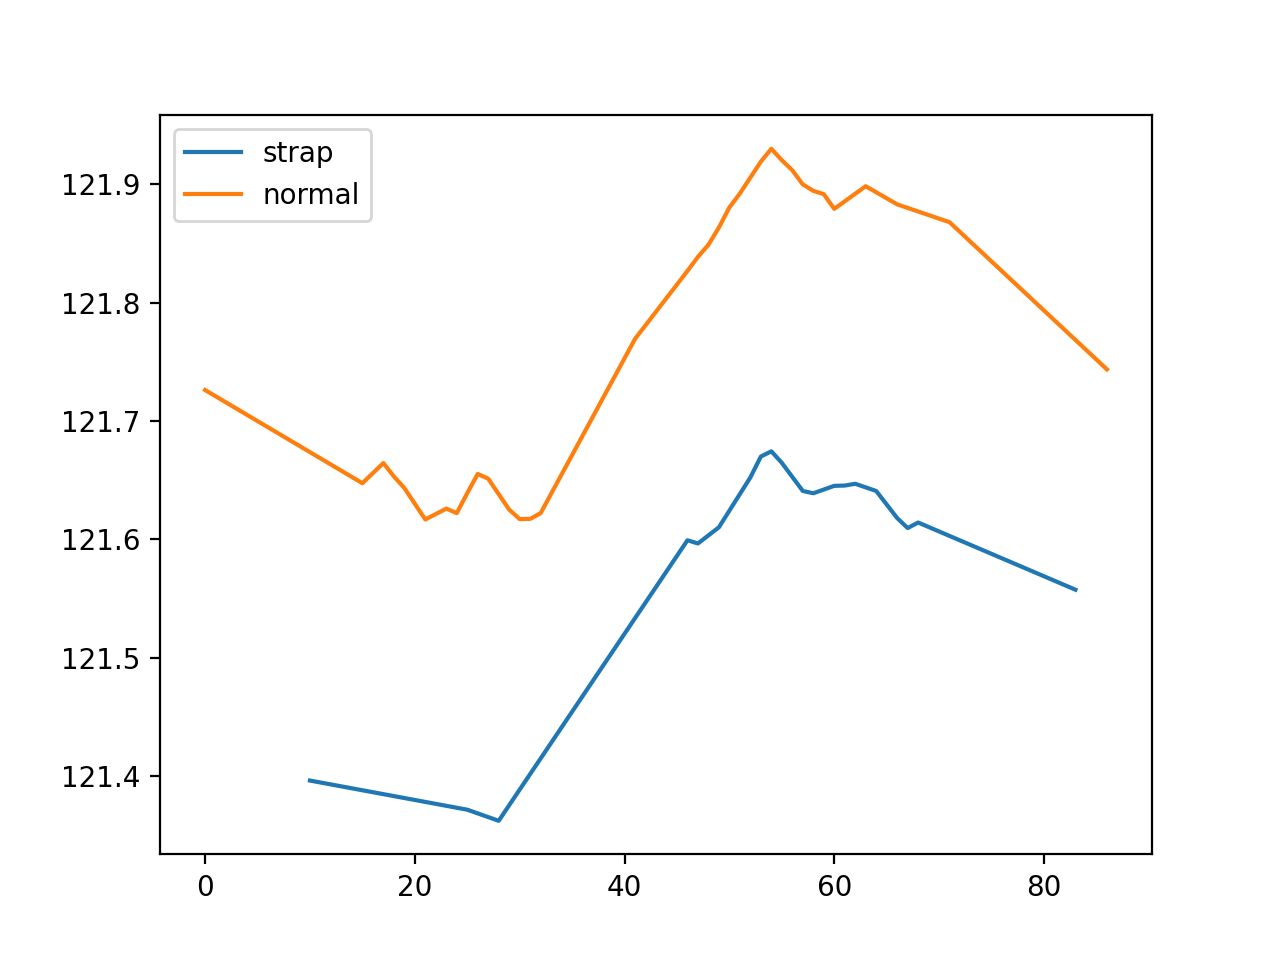

<IPython.core.display.Javascript object>


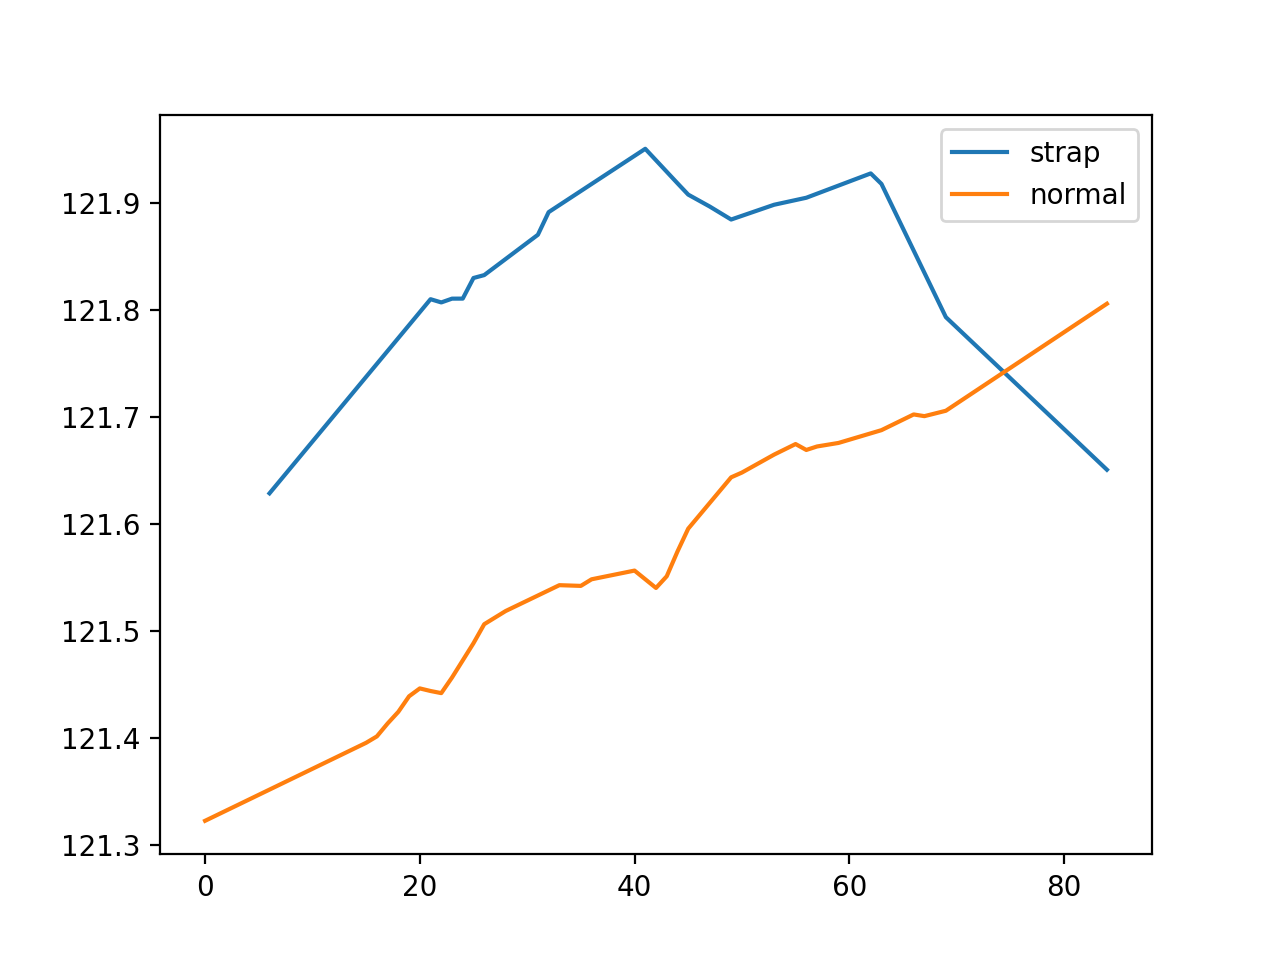

<IPython.core.display.Javascript object>


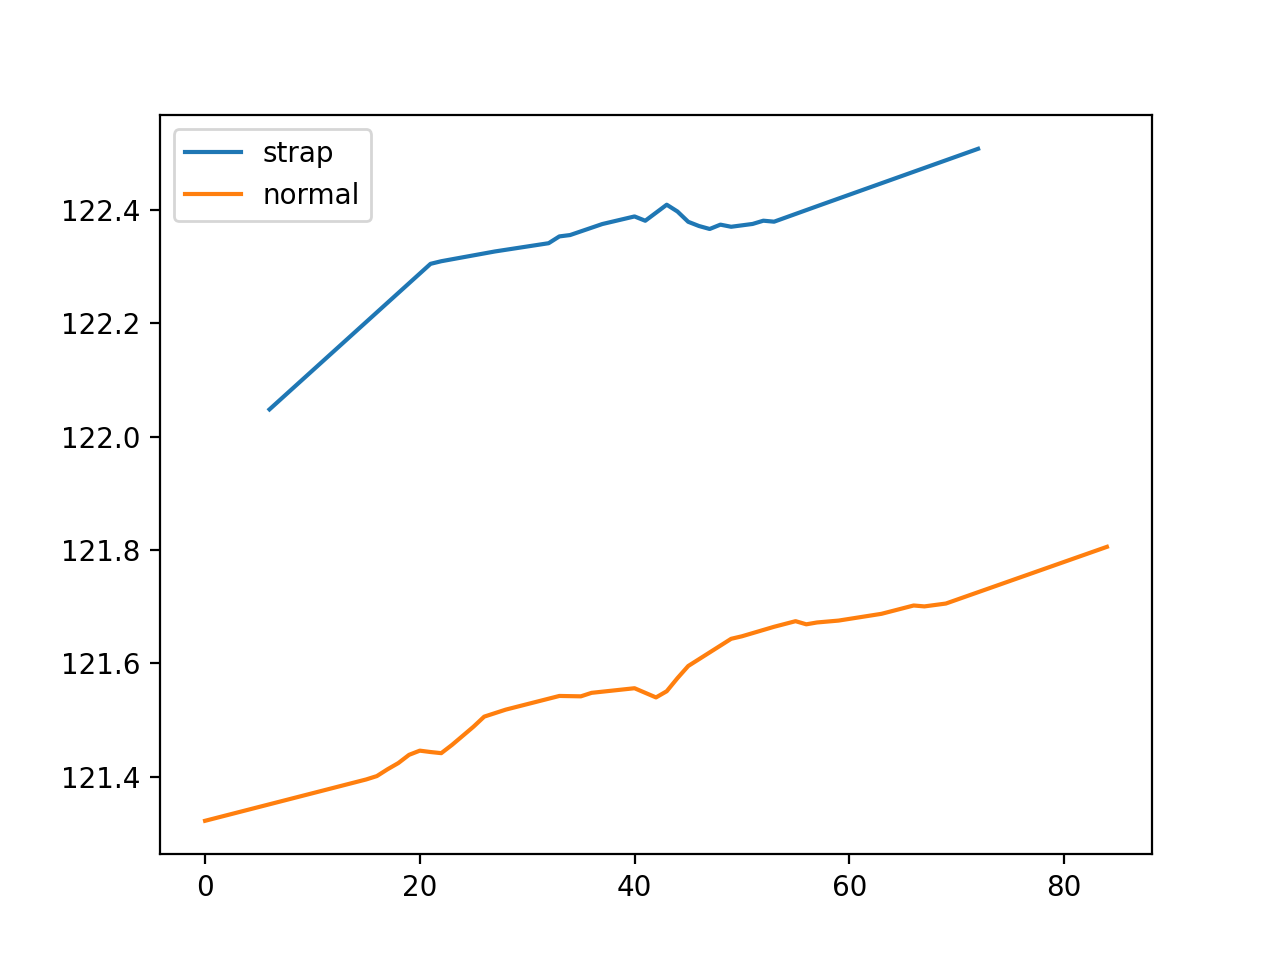

<IPython.core.display.Javascript object>


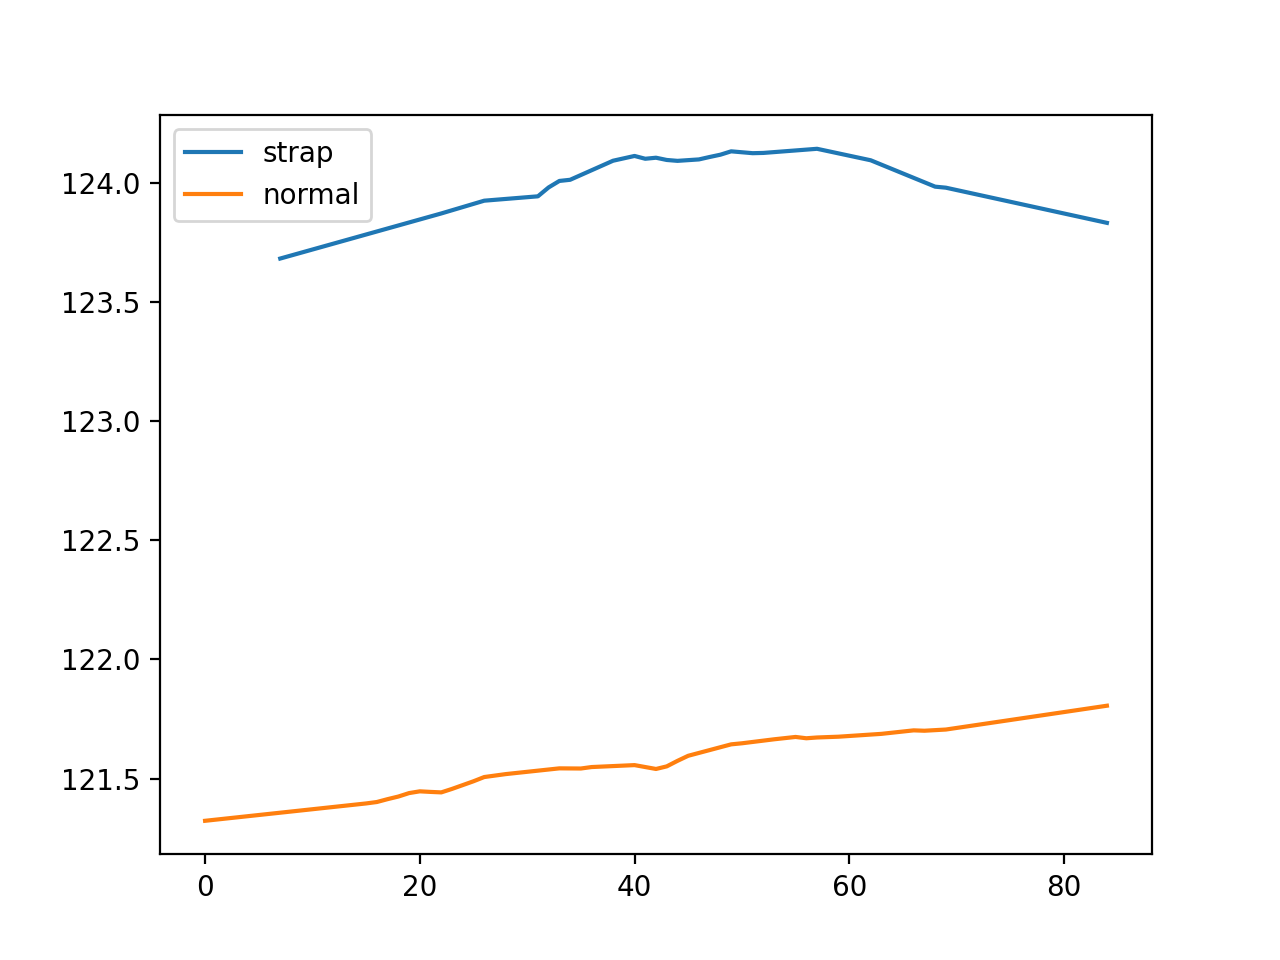

<IPython.core.display.Javascript object>


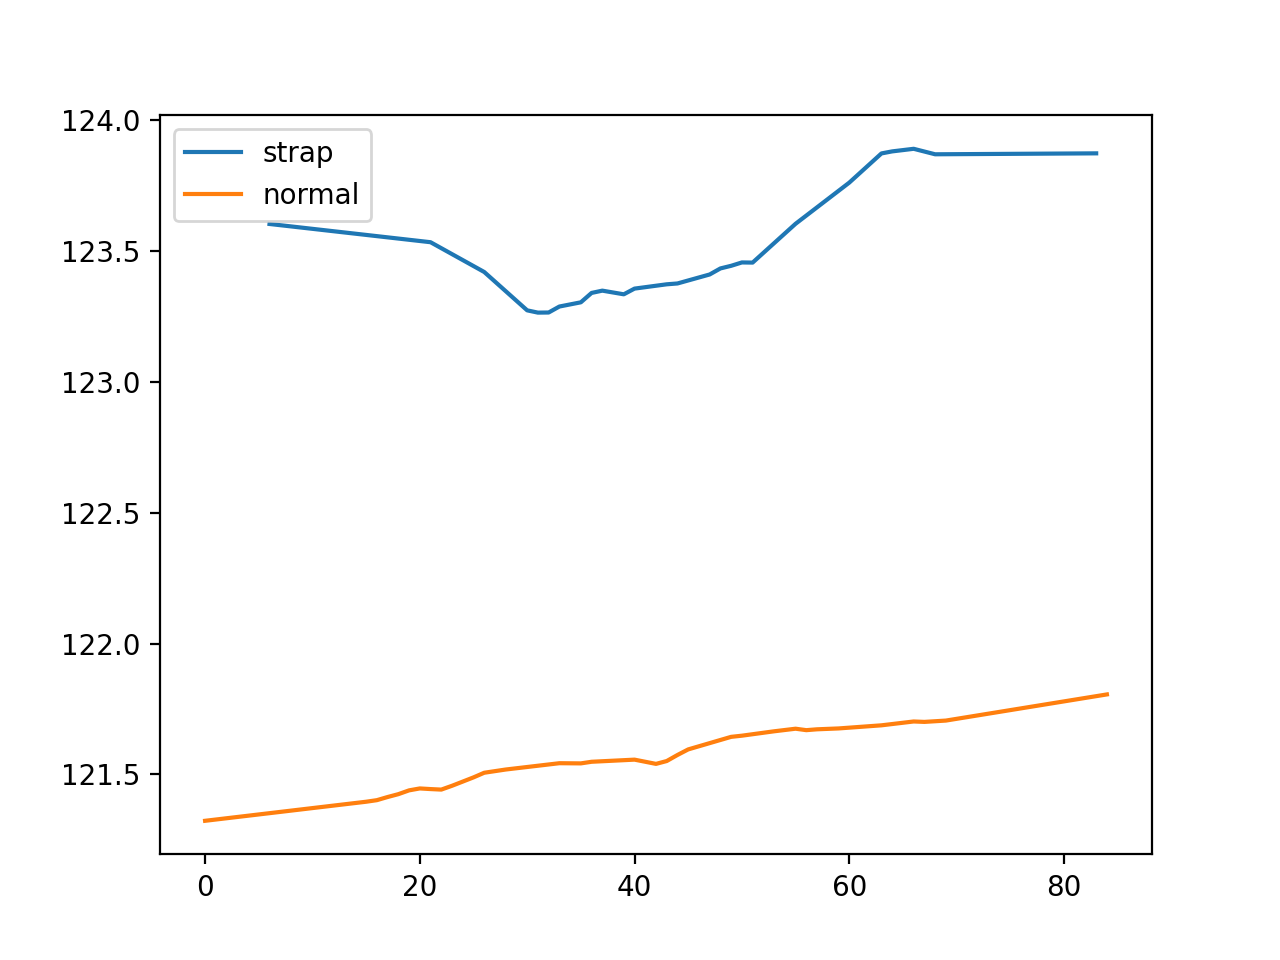

<IPython.core.display.Javascript object>


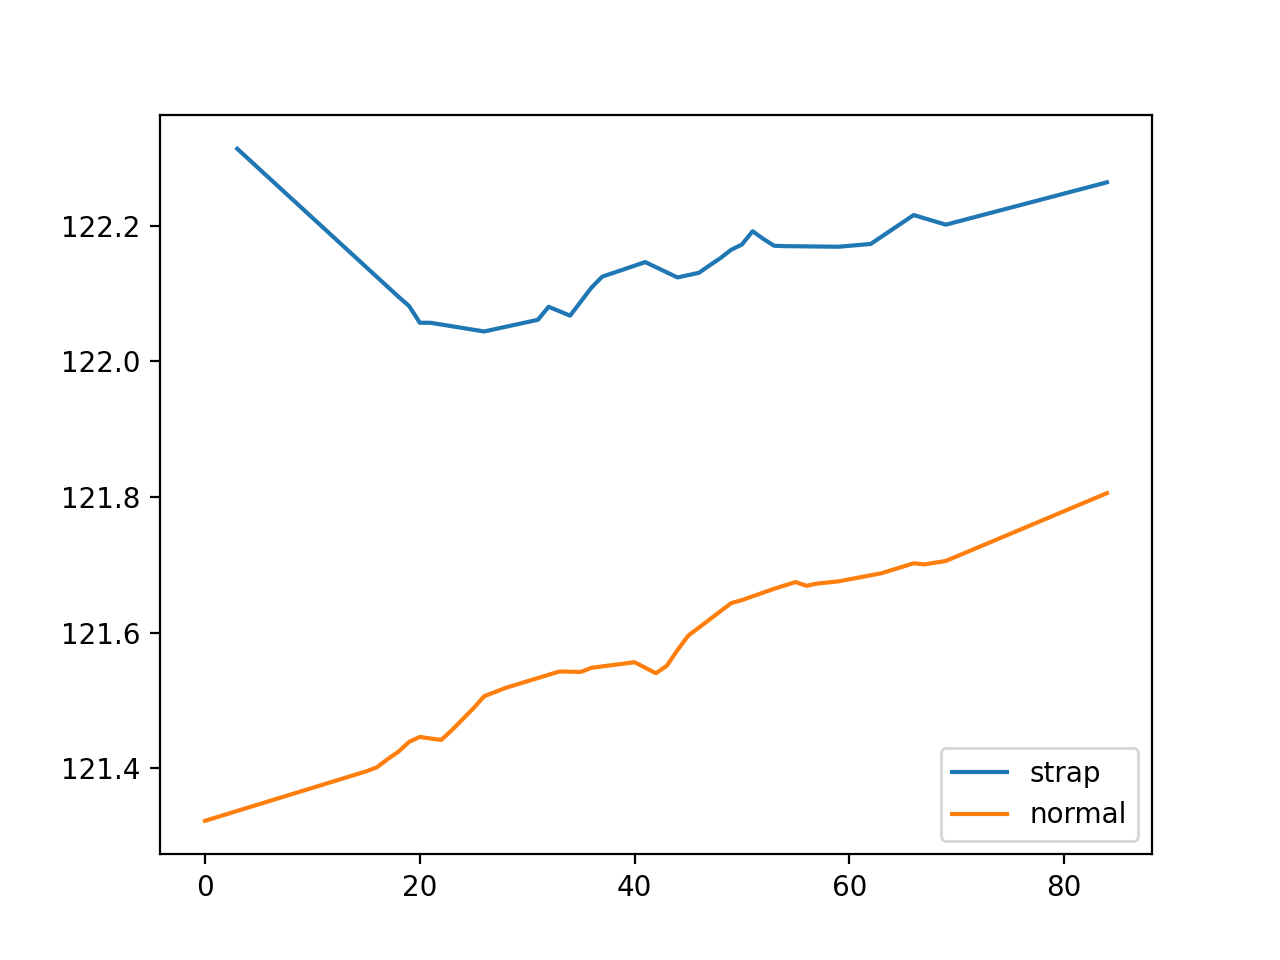

<IPython.core.display.Javascript object>


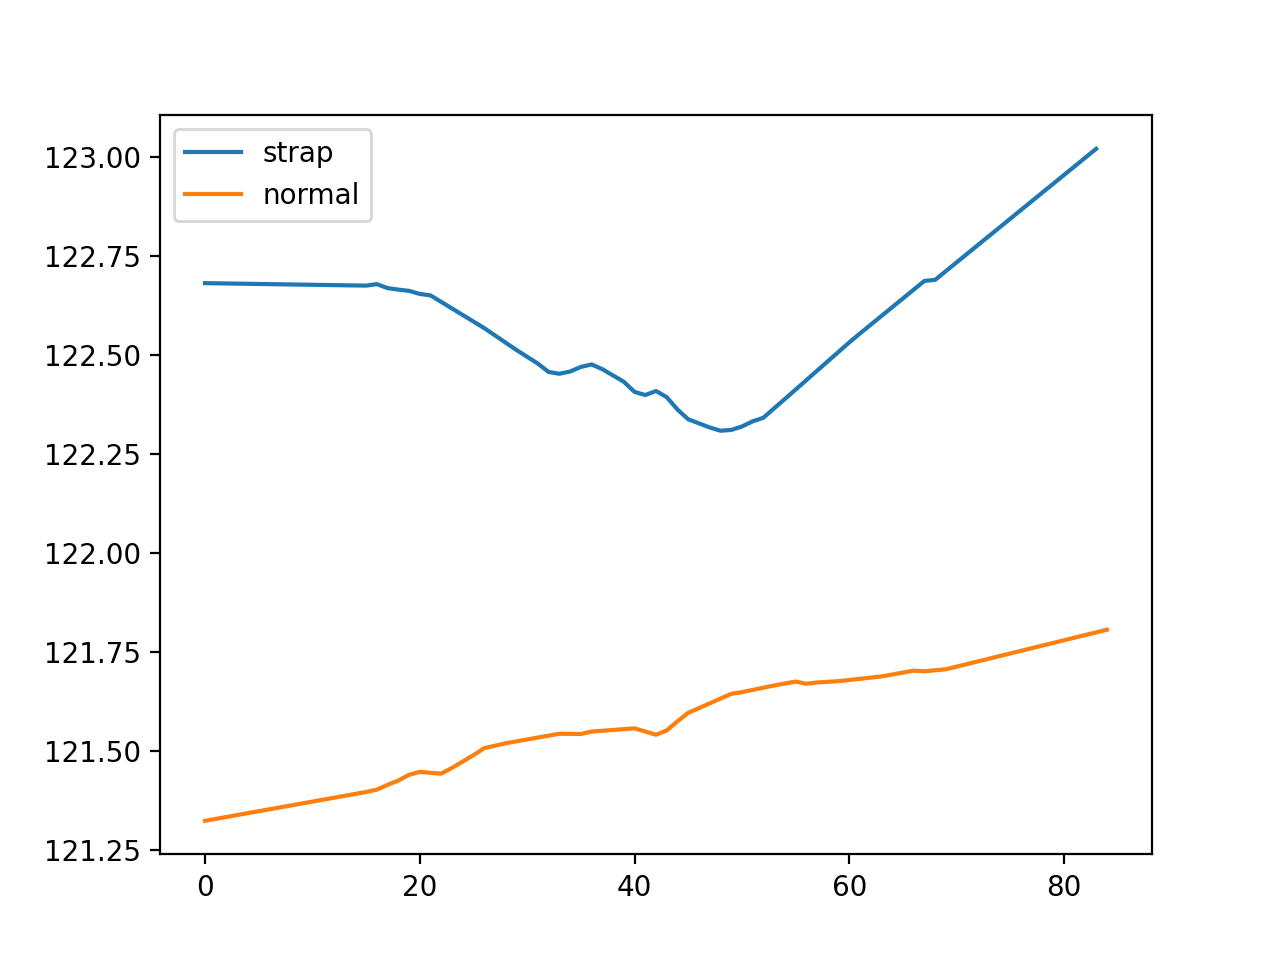

<IPython.core.display.Javascript object>


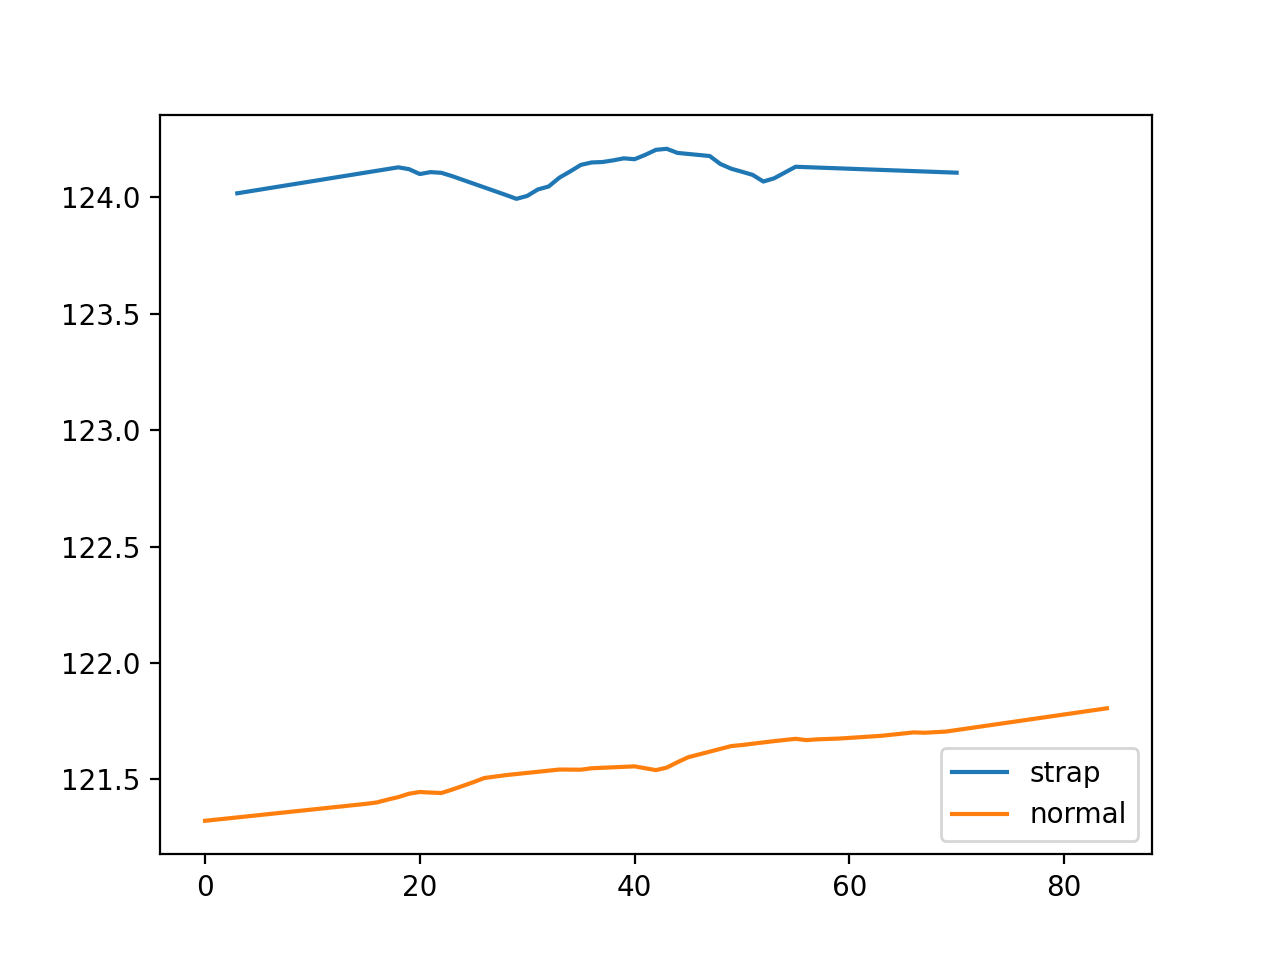

<IPython.core.display.Javascript object>


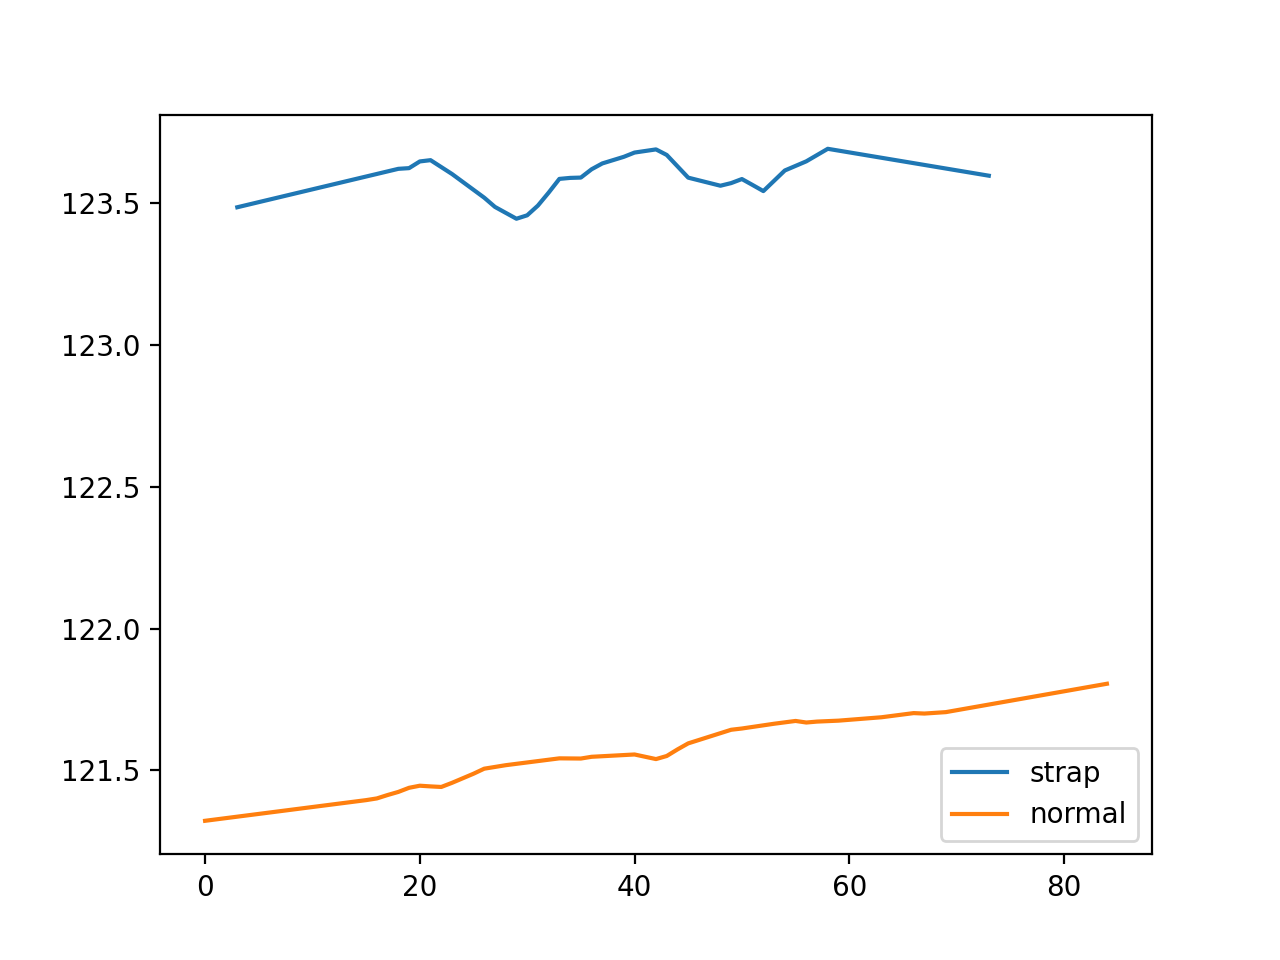

In [48]:
ref = tpf.flux[np.argmin(test)] * sources
qe = correct_straps(ref,mask,parallel=False)

<IPython.core.display.Javascript object>


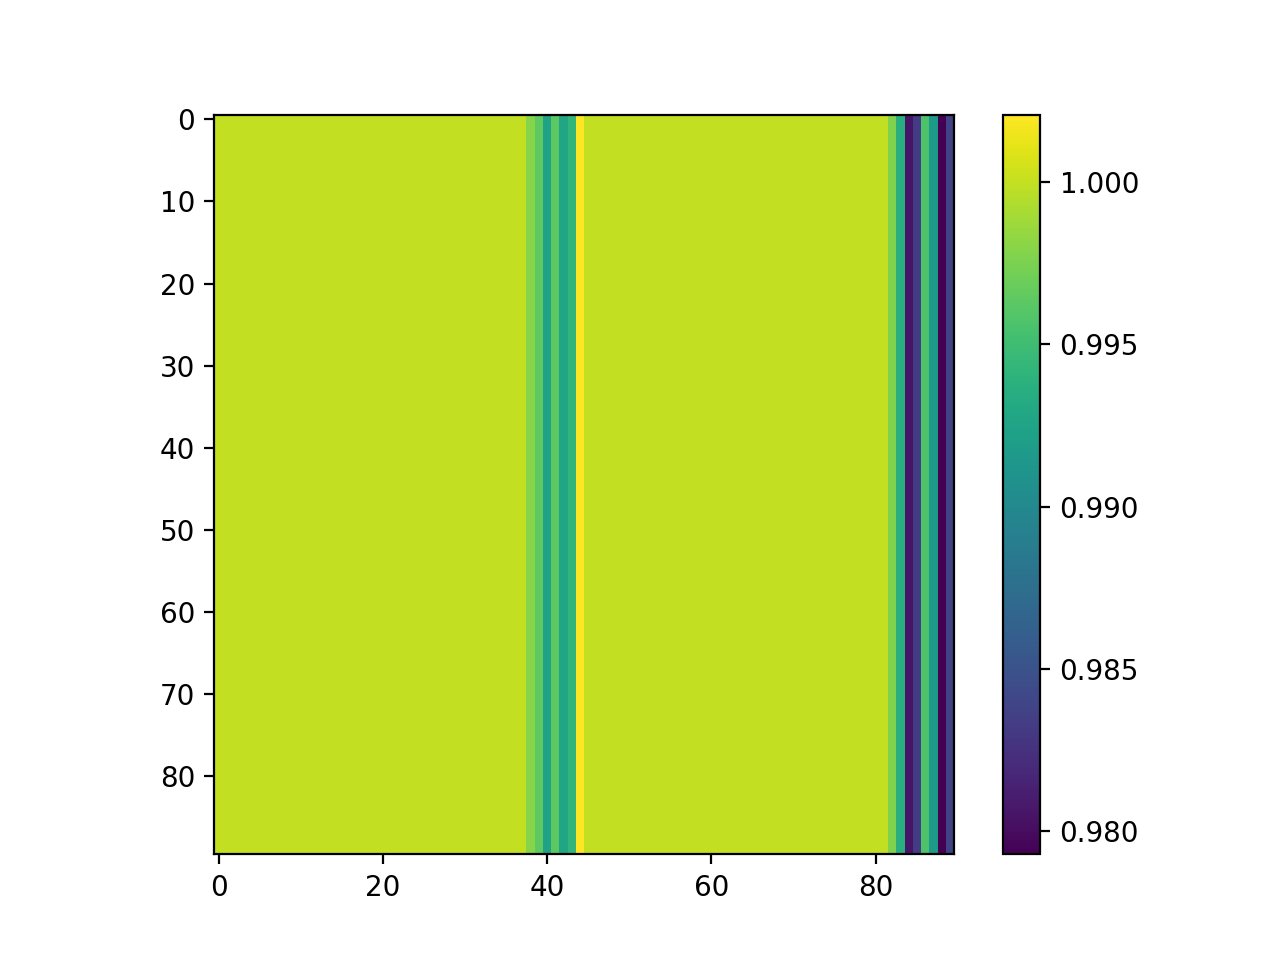

In [50]:
plt.figure()
plt.imshow(qe)
plt.colorbar()

<IPython.core.display.Javascript object>


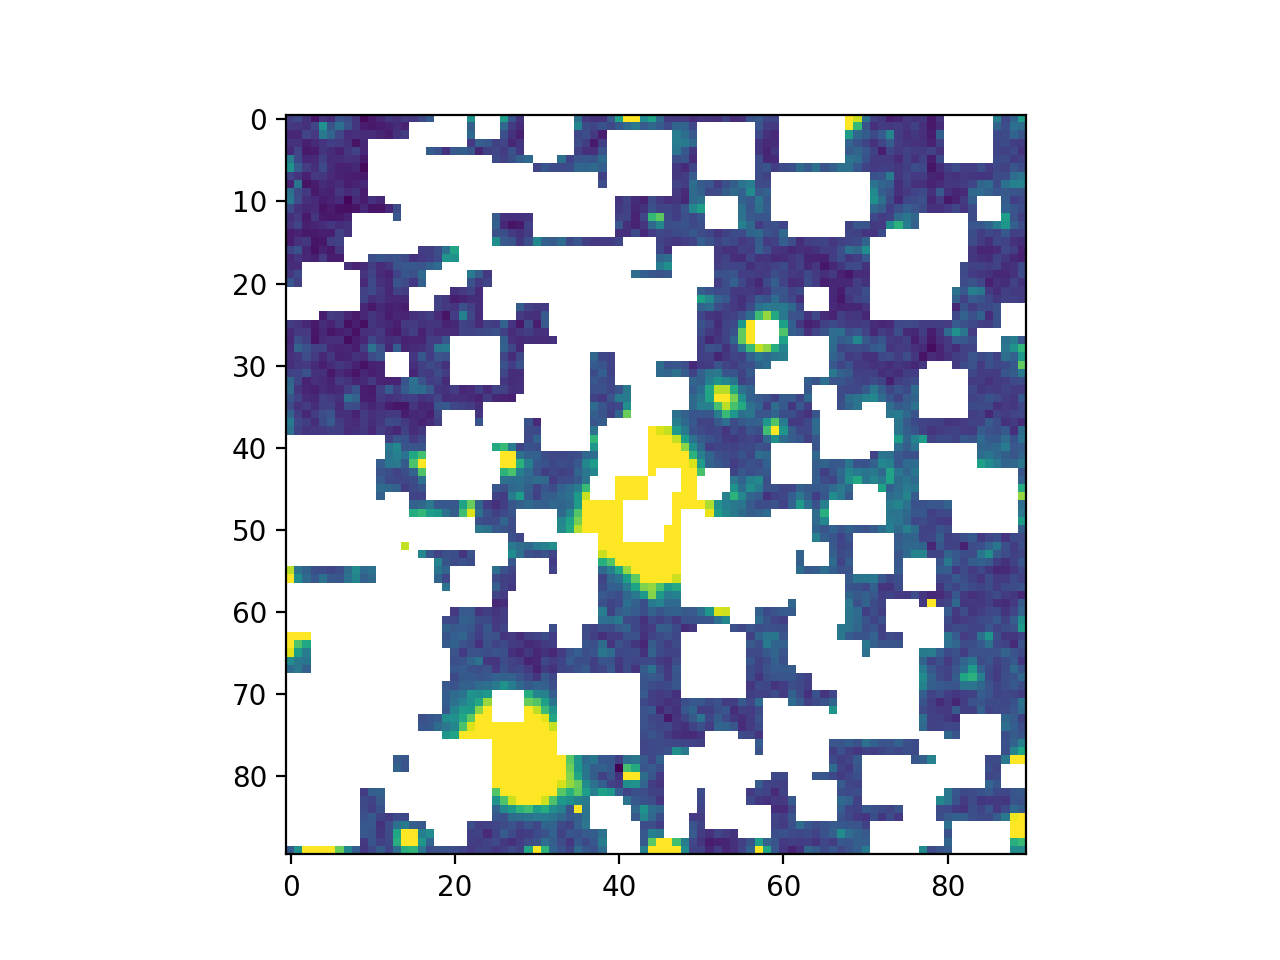

In [43]:
plt.figure()
plt.imshow(qe*ref,vmax=130)

<IPython.core.display.Javascript object>


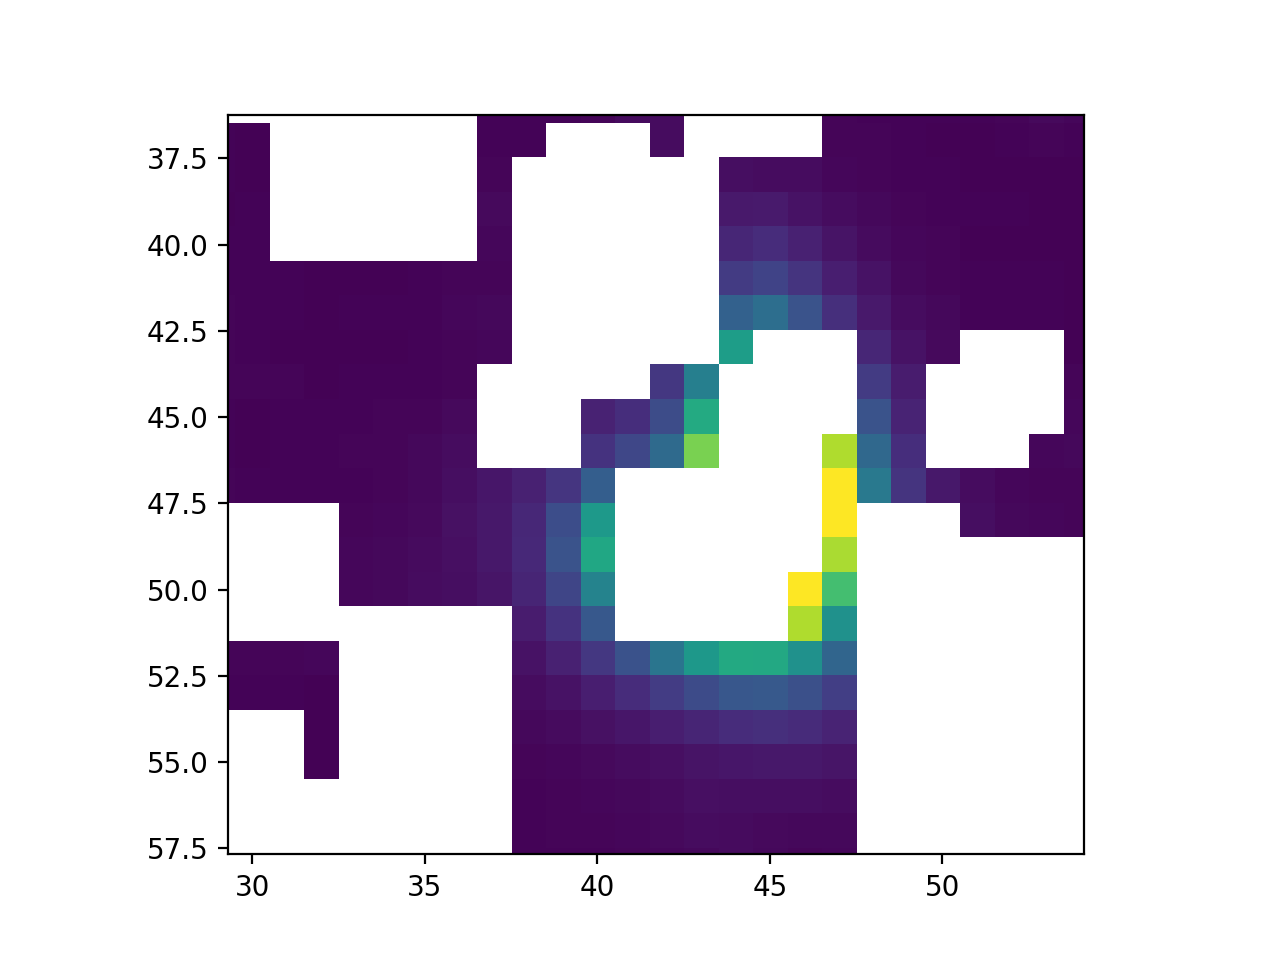

In [38]:
plt.figure()
plt.imshow(tpf.flux[np.argmin(test)] * sources,vmax=400)

<IPython.core.display.Javascript object>


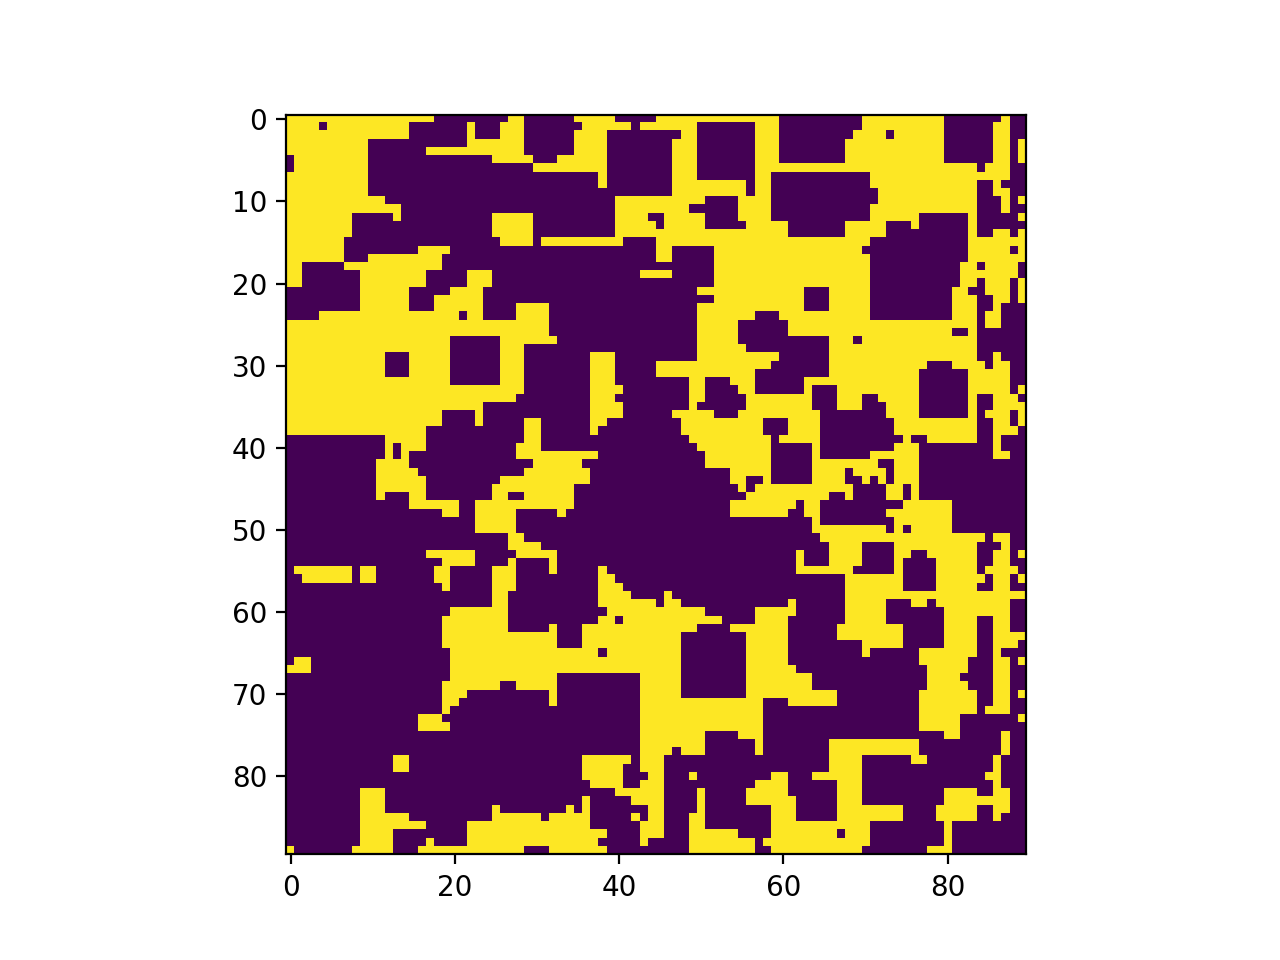

In [40]:
mm = tr.Source_mask(tpf.flux[np.argmin(test)] * sources)
plt.figure()
plt.imshow(mm)

In [8]:
red = tr.Quick_reduce(tpf)

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


In [9]:
flux = red['flux']

<IPython.core.display.Javascript object>


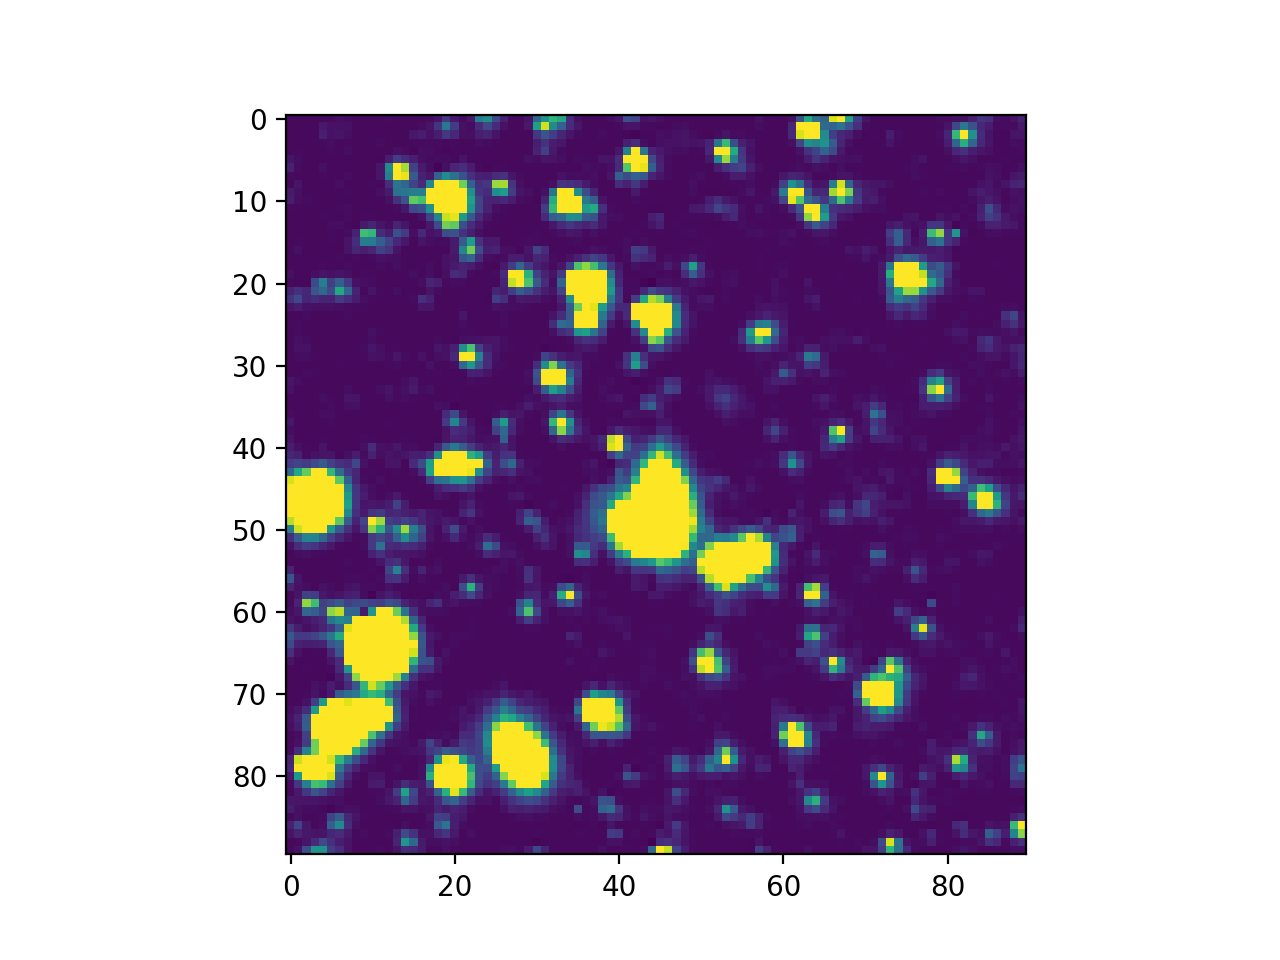

In [12]:
plt.figure()
plt.imshow(flux[1000],vmax=50)

In [7]:
diff = np.sqrt((gp[:,0][:,np.newaxis] - gp[:,0][np.newaxis,:])**2 + (gp[:,1][:,np.newaxis] - gp[:,1][np.newaxis,:])**2)
diff[diff==0] = np.nan

In [8]:
np.nanmin(abs(diff),axis=0)

array([ 6.19868469,  8.3388769 ,  4.34615691,  2.74138296,  5.9583256 ,
        2.34539762,  2.34539762,  0.6441801 ,  0.6441801 ,  4.03184592,
        4.03184592,  7.71519825,  6.19868469,  7.18643699,  4.19610871,
        1.33343454,  1.33343454,  3.14011601,  3.14011601,  4.06838356,
        4.35206005,  4.46843977,  3.04776948,  5.36301393,  0.70586335,
        0.70586335,  2.60030389,  3.02471867,  3.04776948,  5.22919756,
        5.01111875,  5.01111875,  3.36846175,  3.36846175,  3.02471867,
        5.49120819,  6.68518379,  4.23481256,  2.47726851,  2.47726851,
        2.71669192,  1.85243051,  1.85243051,  3.10756608,  3.10756608,
        4.23481256,  1.39591235, 11.96185858,  1.39591235,  4.52159558,
        3.80964399,  5.37698523,  3.80964399,  4.52159558,  5.26711553,
        5.26711553,  1.90727772,  1.90727772,  5.1324096 ,  5.1324096 ,
        3.19595256,  1.96252921,  1.96252921,  2.07269048,  2.4576462 ,
        1.74407883,  2.4576462 ,  0.93809292,  0.93809292,  2.43

In [23]:
def Isolated_stars(pos,Tmag,flux,Median, Distance = 7, Aperture=3, Mag = 16):
    """
    Find isolated stars in the scene.
    """
    
    #pos, Tmag = sd.Get_PS1(tpf,magnitude_limit=18)
    pos_shift = pos + .5
    ind = ((Distance//2< pos_shift[:,0]) & (pos_shift[:,0]< flux.shape[1]-Distance//2) & 
          (Distance//2< pos_shift[:,1]) & (pos_shift[:,1]< flux.shape[1]-Distance//2) &
          (Tmag < Mag))
    
    if ~ind.any():
        raise ValueError('No sources brighter than {} Tmag.'.format(Mag))
    p = pos_shift[ind,:]
    
    distance= np.zeros([len(p),len(p)])
    for i in range(len(p)):
        distance[i] = np.sqrt((p[i,0] - p[:,0])**2 + (p[i,1] - p[:,1])**2)
    distance[distance==0] = np.nan
    mins = np.nanmin(distance,axis=1)
    
    iso = p[mins > Distance]
    iso = iso.astype('int')
    ind[ind] = mins > Distance
    median = Median
    median[median<0] = 0
    if len(iso)> 0:
        clips = []
        time_series = []
        Distance = Aperture
        if (Distance % 2) ==0:
            d = Distance - 1
        else:
            d = Distance
        u = d // 2 + 1
        l = d // 2

        for i in range(len(iso)):
            clips += [median[iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]
            time_series += [flux[:,iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]
        #print(clips)
        clips=np.array(clips)
        time_series=np.array(time_series)
    else:
        raise ValueError('No stars brighter than {} Tmag and isolated by {} pix. Concider lowering brightness.'.format(Mag,Distance))
    return ind, clips, time_series

In [26]:
ref = flux[100]
index, med_cut, stamps = Isolated_stars(gp,gm,flux,ref,Aperture=5,Mag=15)

good = np.ones(len(med_cut))
#good[[6,8,-1]] = 0
good = good > 0
med_cut = med_cut[good]
stamps = stamps[good]

<IPython.core.display.Javascript object>


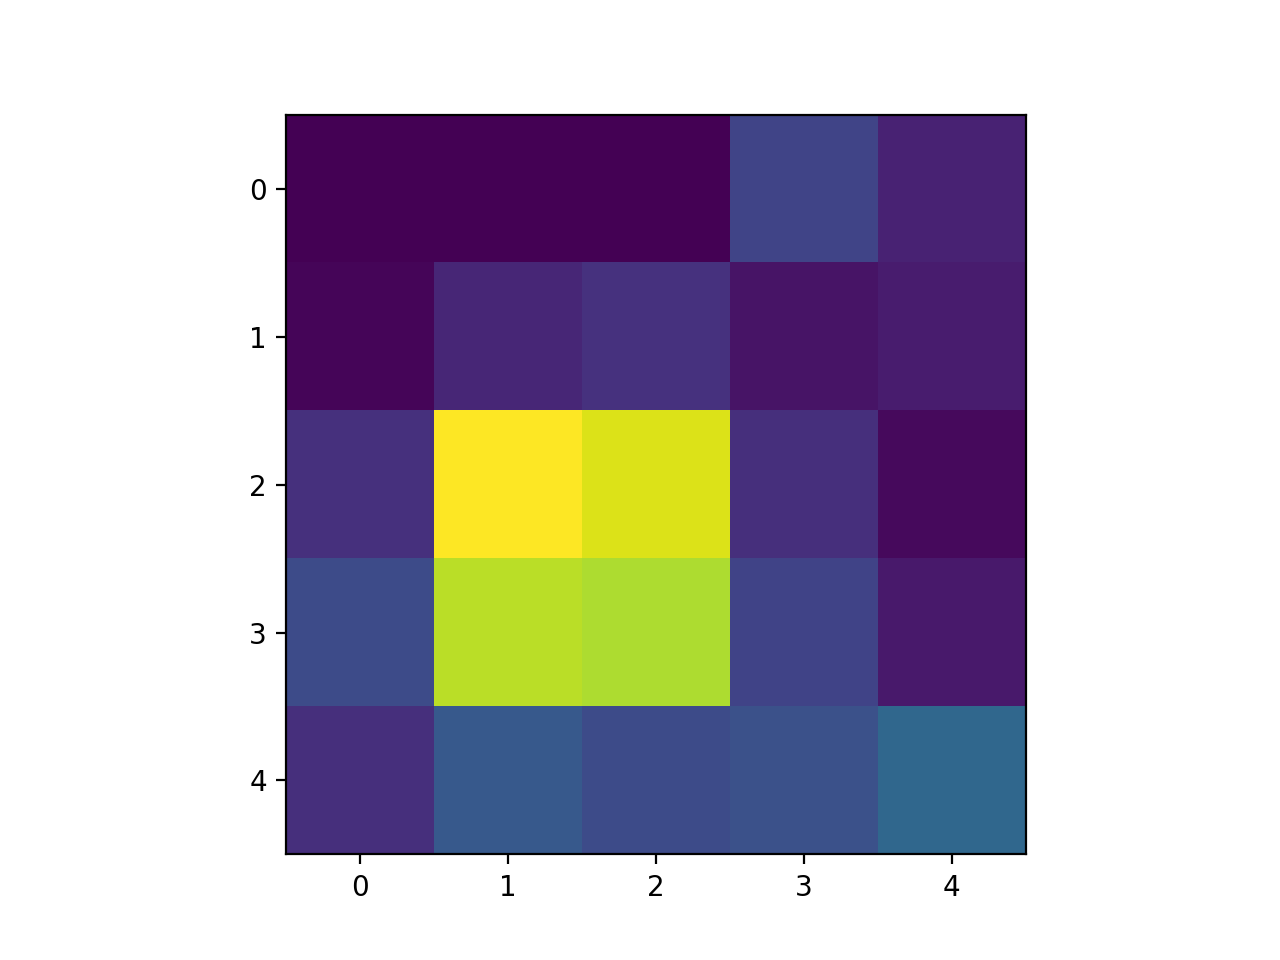

<IPython.core.display.Javascript object>


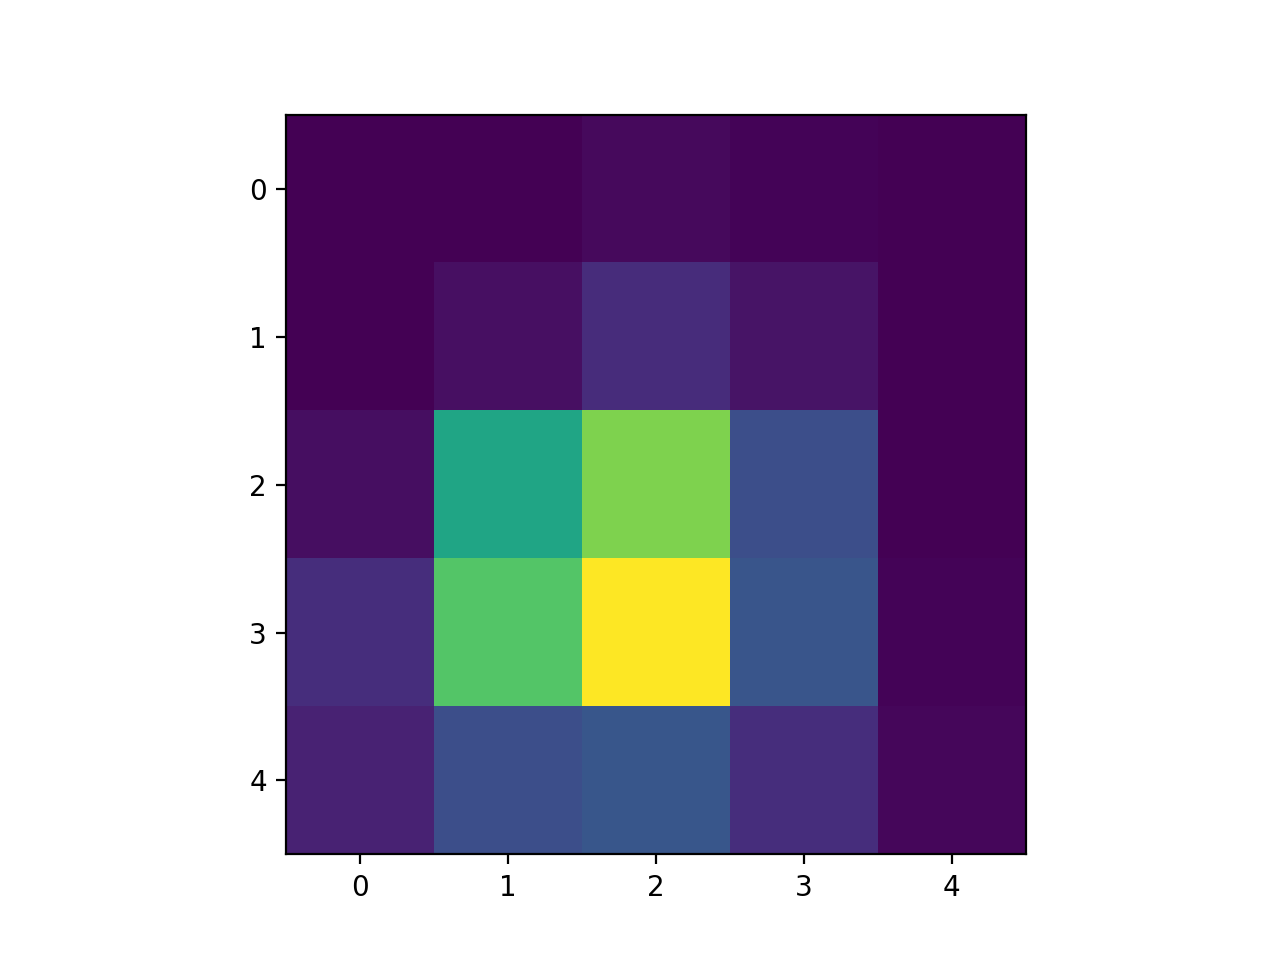

<IPython.core.display.Javascript object>


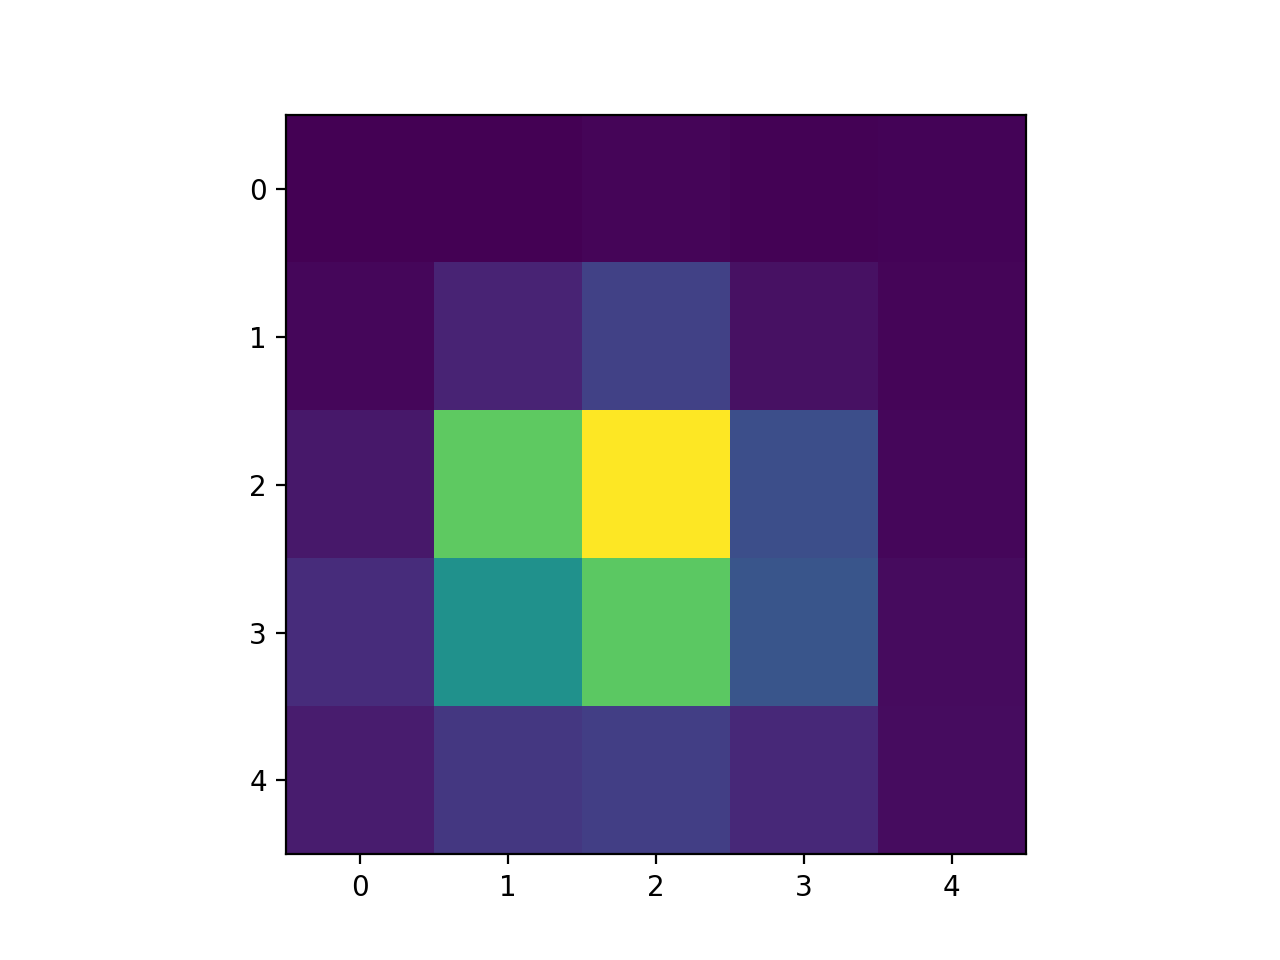

<IPython.core.display.Javascript object>


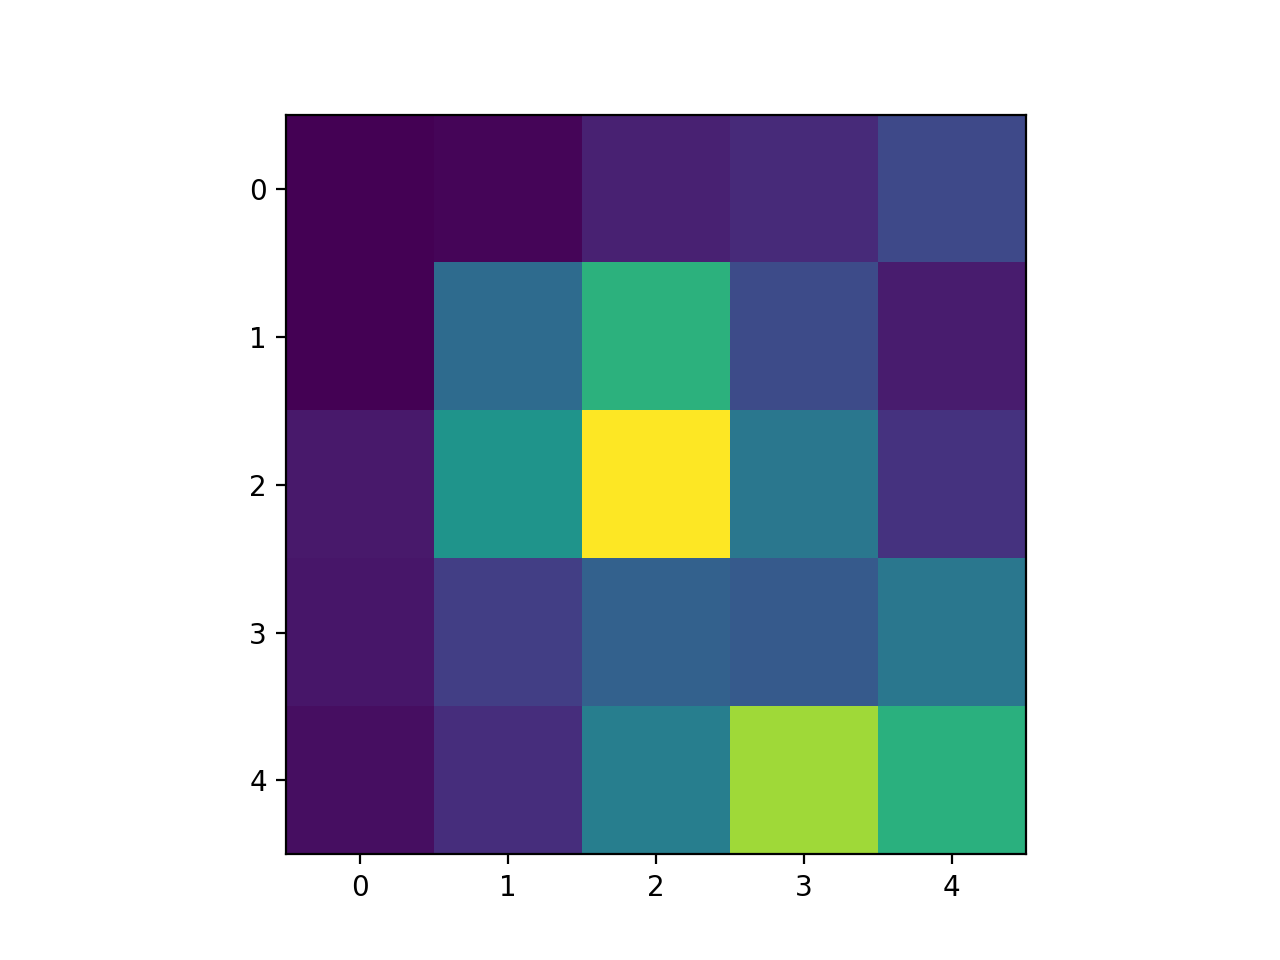

In [27]:
for med in med_cut:
    plt.figure()
    plt.imshow(med)

In [35]:
from photutils import create_matching_kernel


In [50]:
stamps.shape

(13, 1235, 5, 5)

In [84]:
kernels = np.zeros_like(stamps)
for i in range(stamps.shape[0]):
    for j in range(stamps.shape[1]):
        kernel = create_matching_kernel(med_cut[i], stamps[i][j])
        kernels[i,j] = kernel
kernel = np.nanmedian(kernels,axis=0)

In [66]:
from scipy.signal import fftconvolve

In [67]:
from scipy.ndimage.filters import convolve

In [85]:
matched = flux.copy()
for i in range(len(kernel)):
    matched[i] = convolve(flux[i],kernel[i])

<IPython.core.display.Javascript object>


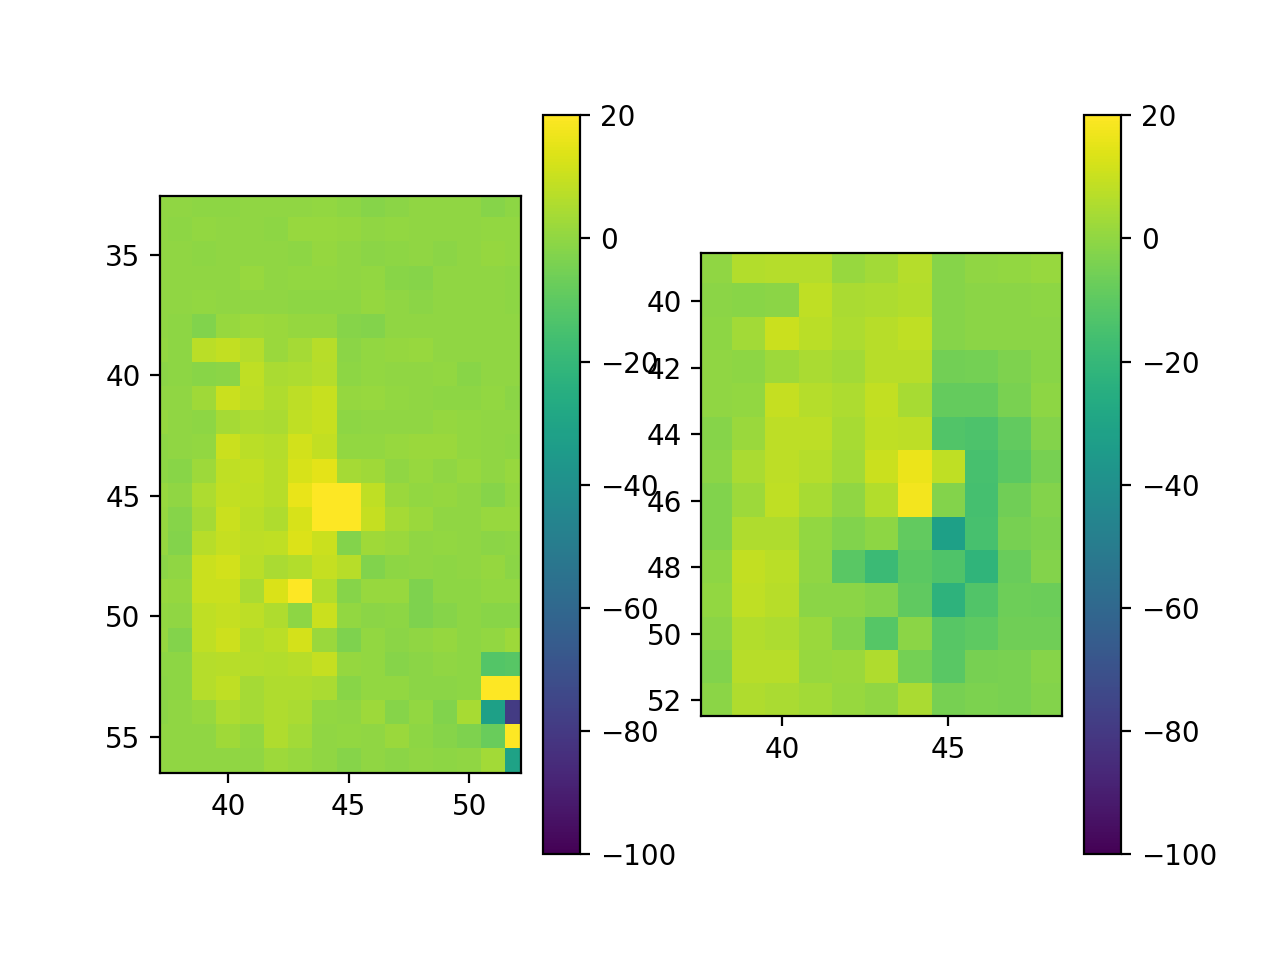

In [103]:

plt.figure()
plt.subplot(121)
plt.imshow(flux[1000]-ref,vmin=-100,vmax=20)
plt.colorbar()

plt.subplot(122)
plt.imshow(matched[1000]-ref,vmin=-100,vmax=20)
plt.colorbar()


In [88]:
matchedlc = tr.Make_lc(tpf.astropy_time.mjd,matched,)
lc = tr.Make_lc(tpf.astropy_time.mjd,flux)

In [89]:
lc.shape

(2, 1235)

<IPython.core.display.Javascript object>


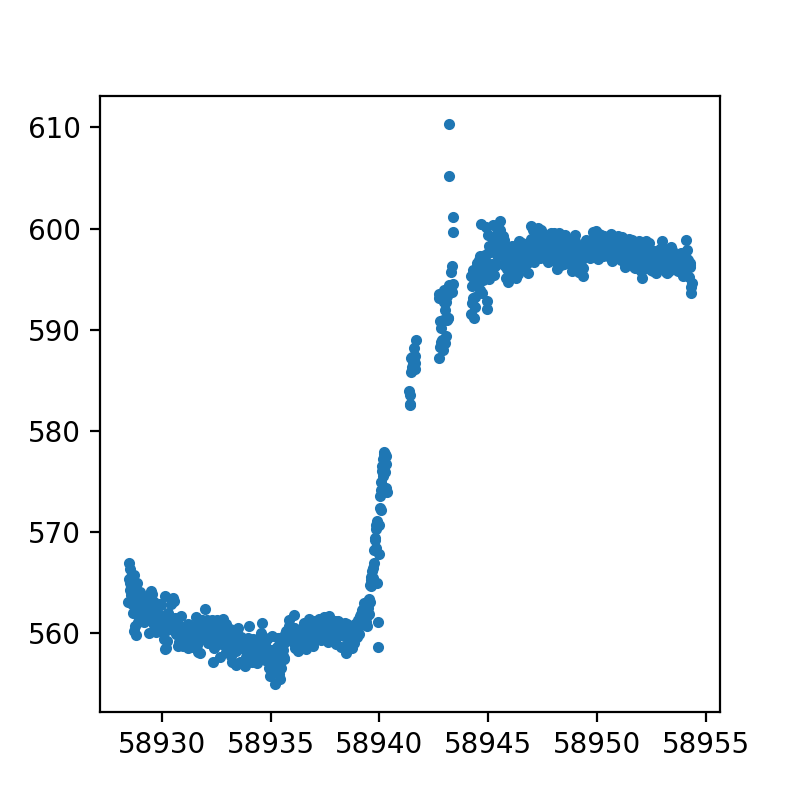

In [109]:
plt.figure(figsize=(4,4))
plt.plot(lc[0],flux[:,45,45],'.')

In [5]:
import pandas as pd

In [21]:
gp, gm = tr.Get_Gaia(tpf)


In [112]:
gp.shape

(241, 2)

In [118]:
gaia = pd.DataFrame(np.array([gp[:,0],gp[:,1],gm]).T,columns=['x','y','mag'])


In [7]:
pp,pm = tr.Get_PS1(tpf)
ps1 = pd.DataFrame(np.array([pp[:,0],pp[:,1],pm]).T,columns=['x','y','mag'])

In [123]:
pp.shape

(350, 2)

In [3]:
mask = tr.Make_mask(tpf)

ModuleNotFoundError: No module named 'cat_mask'

In [ ]:
from tess_stars2px import 